## <font color='blue'>Sommaire</font>

**[Partie 3 - Analyse en Composantes Principales](#partie3)**
* [1. Ebouli des valeurs propres](#1_1)
* [2. Cercle des corrélations](#1_2)
* [3. Projection des individus](#1_3)
* [4. Jointure](#1_4)

**[Partie 4 - Clustering CAH](#partie4)**
* [1. Dendogramme](#4_1)
* [2. Analyse des clusters](#4_2)
* [3. Heatmap des clusters](#4_3)
* [4. Radar charts](#4_4)
* [5. Projection des individus](#4_5)

**[Partie 5 - Clustering K Means](#partie5)**
* [1. Méthode du coude et silhouette score](#5_1)
* [2. Projection des individus](#5_2)
* [3. Analyse des clusters](#5_3)
* [4. Heatmap des clusters](#5_4)
* [5. Radar charts](#5_5)

**[Partie 6 - Comparaison des resultats](#partie6)**
* [1. Matrice de confusion](#6_1)
* [2. Recommandations](#6_2)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.patches import Circle
import plotly.express as px
import seaborn as sns

import scipy.stats as st
from scipy.stats import zscore

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from sklearn.metrics import confusion_matrix


import math

In [2]:
df_complet = pd.read_csv('df_complet_export.csv')

# <font color='blue'>Partie 3 - ACP<a class="anchor" id="partie3"></a></font>

## <font>1. Ebouli des valeurs propres<a class="anchor" id="1_1"></a></font>

In [3]:
# Mettre la colonne 'zone' en index
df_acp = df_complet.set_index('zone')

In [4]:
df_acp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, Arménie to Soudan
Data columns (total 11 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Evol_pop_sur_5ans_(%)                                   146 non-null    float64
 1   Disponibilité alimentaire en quantité (kg/personne/an)  146 non-null    float64
 2   stabilite_politique                                     146 non-null    float64
 3   PIB_hab_($)                                             146 non-null    float64
 4   pop_ss_moyen_alim_saine_(%)                             146 non-null    float64
 5   Distance_from_France_km                                 146 non-null    float64
 6   dispo_prot_animale_(kg/pers/an)                         146 non-null    float64
 7   tx_prod_dispo                                           146 non-null    float64
 8   tx_import_dispo                     

In [5]:
df_acp.shape

(146, 11)

In [6]:
df_acp.head()

,Evol_pop_sur_5ans_(%),Disponibilité alimentaire en quantité (kg/personne/an),stabilite_politique,PIB_hab_($),pop_ss_moyen_alim_saine_(%),Distance_from_France_km,dispo_prot_animale_(kg/pers/an),tx_prod_dispo,tx_import_dispo,tx_prod_import,part_prot_volaille_dispo
zone,,,,,,,,,,,
Arménie,2.06,16.06,-0.62,4041.995071,40.9000,3385.852155,16.26,23.40,74.47,31.43,12.21
Afghanistan,14.15,1.53,-2.80,530.149831,80.2491,5568.133803,3.85,49.12,50.88,96.55,5.11
Albanie,-1.04,16.36,0.38,4521.752219,37.8000,1555.506123,24.21,27.66,80.85,34.21,9.44
Algérie,9.68,6.38,-0.92,4134.936054,35.2000,1384.834206,9.38,99.28,0.72,13750.00,7.67
Angola,15.79,10.56,-0.38,4042.681402,92.9000,6768.083447,6.01,13.17,86.83,15.16,21.86


In [7]:
# Matrice des données 
X = df_acp.values

In [8]:
# Vérifier la dimension
X.shape

(146, 11)

In [9]:
# Noms des individus
names = df_acp.index

# Noms des variables
features = df_acp.columns

p = df_acp.shape[1] # nb de variables

In [10]:
# Instanciation
scaler = StandardScaler()

# Fit and transform
X_scaled = scaler.fit_transform(X)

# Visualisation de la moyenne et de l'écart-type : attendu moy = 0 et std =1
idx = ["mean", "std"]
pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

,0,1,2,3,4,5,6,7,8,9,10
mean,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [11]:
# Instanciation de l'ACP
pca2 = PCA()

# Entraînement sur les données scalées
pca2.fit(X_scaled)

PCA()

In [12]:
scree = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(p)], 
        "Variance expliquée" : pca2.explained_variance_,
        "% variance expliquée" : np.round(pca2.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : np.round(np.cumsum(pca2.explained_variance_ratio_) * 100)
    }
)
scree

,Dimension,Variance expliquée,% variance expliquée,% cum. var. expliquée
0,Dim1,4.037231,36.0,36.0
1,Dim2,1.797142,16.0,53.0
2,Dim3,1.512328,14.0,66.0
3,Dim4,0.904072,8.0,74.0
4,Dim5,0.855357,8.0,82.0
5,Dim6,0.721155,7.0,89.0
6,Dim7,0.526432,5.0,93.0
7,Dim8,0.281607,3.0,96.0
8,Dim9,0.221119,2.0,98.0
9,Dim10,0.167528,2.0,100.0


In [13]:
# Fixer un seuil de variance expliquée (ex. 80%)
seuil_variance = 0.80

# Calculer le nombre de composantes nécessaires pour atteindre ce seuil
nb_composantes = sum(scree['% cum. var. expliquée'] <= (seuil_variance * 100))
print(f"Nombre de composantes retenues pour expliquer {seuil_variance*100}% de la variance : {nb_composantes}")


Nombre de composantes retenues pour expliquer 80.0% de la variance : 4


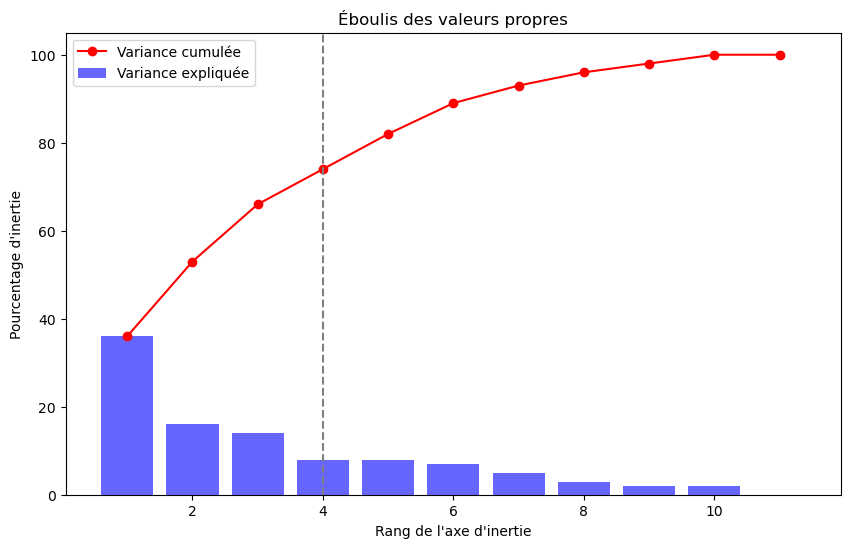

In [14]:
# Liste des composants (indice des composantes)
x_list = range(1, p+1)

# Représentation graphique des valeurs propres avec la méthode du coude
plt.figure(figsize=(10, 6))
plt.bar(x_list, scree['% variance expliquée'], alpha=0.6, color='blue', label='Variance expliquée')
plt.plot(x_list, scree['% cum. var. expliquée'], c="red", marker='o', label='Variance cumulée')

# Ajouter une ligne
plt.axvline(x=4, linestyle='--', color='gray') 

plt.xlabel("Rang de l'axe d'inertie")
plt.ylabel("Pourcentage d'inertie")
plt.title("Éboulis des valeurs propres")
plt.legend()
plt.show()

PC1 (Première composante) explique près de 40 % de la variance totale. C'est donc la direction qui capture le plus d'information parmi toutes les composantes.

PC2 explique environ 20 % de l'inertie. Avec les deux premières composantes, on explique donc environ 60 % de la variance totale, ce qui est déjà une grande partie de l'information.

En ajoutant les composantes PC3 et PC4, on atteint environ 75 % de la variance expliquée. Cela montre qu'après les deux premières composantes, chaque composante suivante ajoute de moins en moins d'information.

Au-delà de la composante PC6, les barres deviennent beaucoup plus petites, signifiant que les composantes restantes n'apportent que peu d'information supplémentaire.

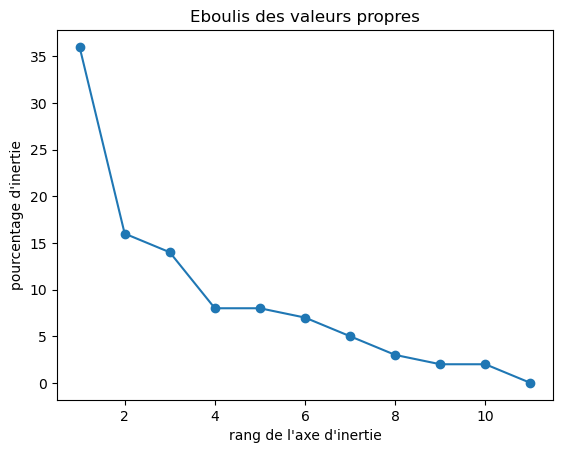

In [15]:
# Représentation graphiques des valeurs propres - méthode du coude
plt.plot(x_list, scree['% variance expliquée'],marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

Ce graphique confirme le précédent:

Il semble que les deux premières composantes (PC1 et PC2) expliquent ensemble une grande part de l'information (environ 50 %).

Les quatre premières composantes (PC1 à PC4) expliquent environ 75 % de la variance, ce qui est souvent suffisant pour des visualisations ou des analyses.

Les composantes suivantes apportent moins d'information, et leur contribution à l'inertie est marginale.

## <font>2. Cercle des corrélations<a class="anchor" id="1_2"></a></font>

In [16]:
# Nombre de composantes principales 
n_components = 4

# Instanciation de l'ACP
pca = PCA(n_components=n_components)

# Entraînement sur les données scalées
pca.fit(X_scaled)

pca_result = pca.fit_transform(X_scaled)

In [17]:
# Principal Components = PCs
pcs = pd.DataFrame(pca.components_)

In [18]:
# Appliquer les colonnes et les index à 'pcs'
pcs.columns = features  # Colonnes des variables
pcs.index = [f"PC{i}" for i in range(1, n_components+1)]  # Index des composantes principales

In [19]:
pcs

,Evol_pop_sur_5ans_(%),Disponibilité alimentaire en quantité (kg/personne/an),stabilite_politique,PIB_hab_($),pop_ss_moyen_alim_saine_(%),Distance_from_France_km,dispo_prot_animale_(kg/pers/an),tx_prod_dispo,tx_import_dispo,tx_prod_import,part_prot_volaille_dispo
PC1,-0.335915,0.360114,0.355739,0.377110,-0.458113,-0.137354,0.461884,0.160697,0.061632,0.021594,0.128676
PC2,0.028320,0.400161,-0.156570,-0.160891,-0.021303,0.432595,-0.079831,0.163853,-0.440774,0.387981,0.472277
PC3,0.274822,0.258656,0.162646,0.060638,0.078918,0.138810,-0.029497,-0.597461,0.429230,-0.188947,0.473471
PC4,-0.003144,-0.154334,0.530727,0.105711,0.056576,0.743882,0.010254,-0.009063,-0.101251,-0.138696,-0.311590


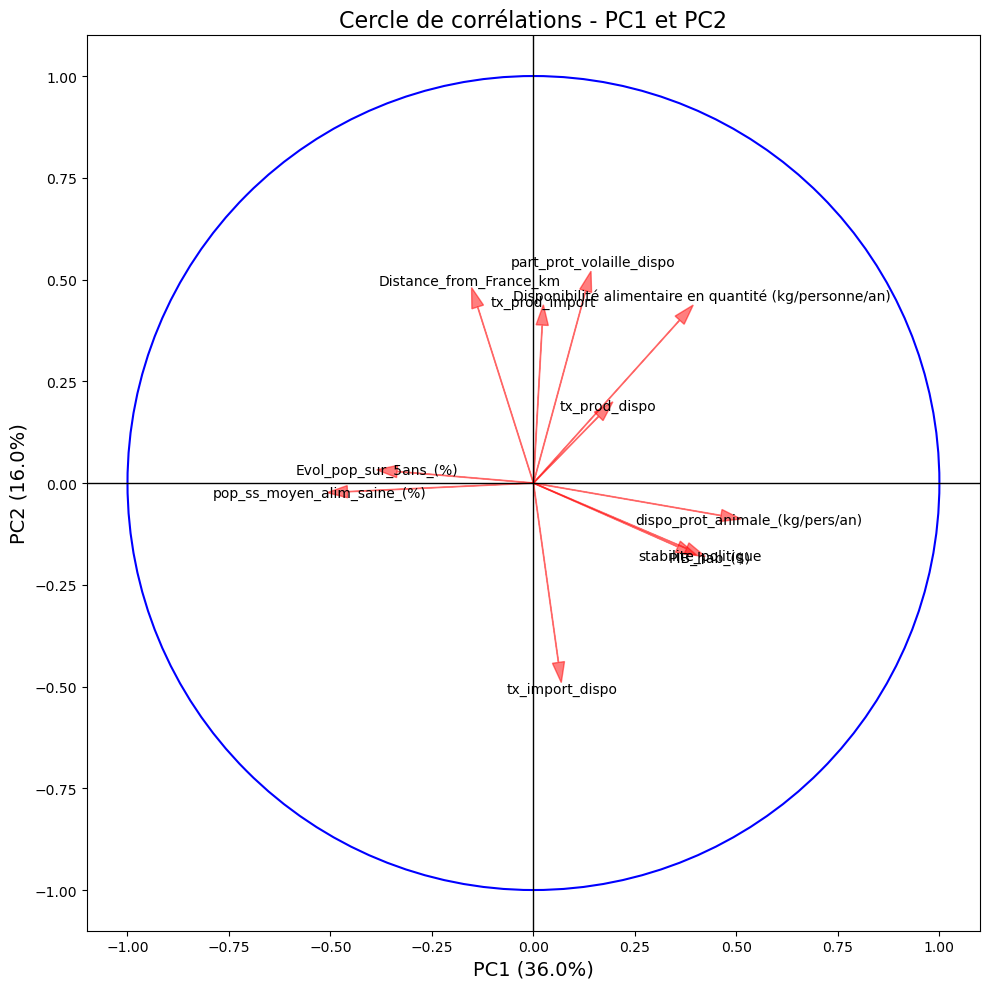

Cos² des variables sur PC1:
Evol_pop_sur_5ans_(%)                                     0.596469
Disponibilité alimentaire en quantité (kg/personne/an)    0.340792
stabilite_politique                                       0.275595
PIB_hab_($)                                               0.777328
pop_ss_moyen_alim_saine_(%)                               0.955027
Distance_from_France_km                                   0.024230
dispo_prot_animale_(kg/pers/an)                           0.966703
tx_prod_dispo                                             0.063028
tx_import_dispo                                           0.009676
tx_prod_import                                            0.002264
part_prot_volaille_dispo                                  0.029521
dtype: float64

Cos² des variables sur PC2:
Evol_pop_sur_5ans_(%)                                     0.004240
Disponibilité alimentaire en quantité (kg/personne/an)    0.420801
stabilite_politique                                      

In [20]:
# Sélectionner les deux premières composantes
pc1 = pcs.iloc[0, :]  # Première composante principale
pc2 = pcs.iloc[1, :]  # Deuxième composante principale

# Tracer le cercle de corrélations
fig, ax = plt.subplots(figsize=(10, 10))

# Tracer un cercle unité
circle = Circle((0, 0), 1, facecolor='none', edgecolor='b', lw=1.5)
ax.add_patch(circle)

# Ajouter les flèches représentant les variables dans l'espace des PC1 et PC2
for i in range(len(pc1)):
    ax.arrow(0, 0, pc1[i], pc2[i], color='r', alpha=0.5, head_width=0.03, head_length=0.05)
    ax.text(pc1[i] * 1.15, pc2[i] * 1.15, pcs.columns[i], color='black', ha='center', va='center', fontsize=10)

# Ajouter des lignes pour les axes
plt.axhline(0, color='black', lw=1)
plt.axvline(0, color='black', lw=1)

# Pourcentages de variance expliquée
variance_pc1 = 36.0  # Pourcentage de variance expliquée pour PC1
variance_pc2 = 16.0  # Pourcentage de variance expliquée pour PC2

# Ajouter les limites et le titre
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_xlabel(f'PC1 ({variance_pc1:.1f}%)', fontsize=14)
ax.set_ylabel(f'PC2 ({variance_pc2:.1f}%)', fontsize=14)
plt.title('Cercle de corrélations - PC1 et PC2', fontsize=16)

# Améliorer l'espacement
plt.tight_layout()
plt.show()

# Calculer la somme des carrés des coordonnées pour chaque variable (norme au carré)
norm_squared = pcs.apply(lambda x: x**2, axis=0).sum()

# Calculer le cos² pour PC1 et PC2
cos2_pc1 = (pcs.iloc[0, :]**2) / norm_squared
cos2_pc2 = (pcs.iloc[1, :]**2) / norm_squared

# Afficher les résultats
print("Cos² des variables sur PC1:")
print(cos2_pc1)
print("\nCos² des variables sur PC2:")
print(cos2_pc2)



 # Analyse du Cercle des Corrélations (PC1 et PC2)

Ce graphique représente les corrélations entre les variables et les deux premières composantes principales de l'Analyse en Composantes Principales (ACP). Le cercle des corrélations permet de visualiser quelles variables sont les plus influentes sur PC1 et PC2, ainsi que leurs relations entre elles.

### Variables bien représentées sur PC1

PC1 capture une grande partie de la variance dans les données, avec une forte représentation des variables économiques et démographiques :

- **PIB par habitant ($)** (Cos² = 0.777) et **disponibilité en protéines animales (kg/personne/an)** (Cos² = 0.967) sont **fortement corrélées positivement** avec PC1. Cela signifie que les pays avec un PIB plus élevé et une meilleure disponibilité en protéines animales se situent à des valeurs plus élevées sur cet axe.
  
- **Taux de population sous-alimentée (%)** (Cos² = 0.955) est **fortement corrélée négativement** avec PC1, ce qui indique que les pays où la population sous-alimentée est élevée ont tendance à être plus bas sur cet axe.

- **Disponibilité alimentaire en quantité (kg/personne/an)** (Cos² = 0.341) est également représentée sur PC1, bien qu'elle soit moins influente que les variables économiques.

- **Stabilité politique** (Cos² = 0.276) est légèrement corrélée à PC1, ce qui signifie que les pays politiquement stables tendent également à avoir un impact positif sur cet axe.

- **Distance de la France** (Cos² = 0.024) et **part de protéines volaille disponibles** (Cos² = 0.030) sont faiblement représentées sur PC1, avec un impact limité.

### Variables bien représentées sur PC2

PC2 capte principalement des variables liées aux échanges alimentaires et à la production :

- **Taux d'import disponible (tx_import_dispo)** (Cos² = 0.495) et **taux de production importée (tx_prod_import)** (Cos² = 0.731) sont **fortement corrélés positivement** avec PC2. Ces variables indiquent les pays dont l'économie alimentaire est fortement liée à l'importation et à la production internationale.

- **Disponibilité alimentaire en quantité (kg/personne/an)** (Cos² = 0.421) est également bien représentée sur PC2, montrant une corrélation entre la quantité d'aliments disponibles et la position des pays sur cet axe.

- **Part de protéines volaille disponibles** (Cos² = 0.398) influence également PC2 de manière significative, suggérant que les pays disposant de plus de volaille dans leur régime alimentaire sont plus influencés par cet axe.

- Les autres variables, telles que **PIB par habitant ($)** (Cos² = 0.141), **stabilité politique** (Cos² = 0.053), et **distance de la France** (Cos² = 0.240), ont un impact plus faible sur PC2.

### Conclusion

Le cercle des corrélations montre que **PC1** capte principalement des variables économiques comme le **PIB** et la **disponibilité en protéines animales**, tandis que **PC2** est influencé par des variables d'échange alimentaire et de production, comme le **taux d'importation** et la **production importée**.

- **PC1** représente donc principalement la stabilité économique et alimentaire.
- **PC2** capte les aspects commerciaux et les échanges alimentaires entre pays.

Cette distinction est cruciale pour segmenter les pays selon leur potentiel pour l'exportation de produits alimentaires, notamment en matière de poulet bio.


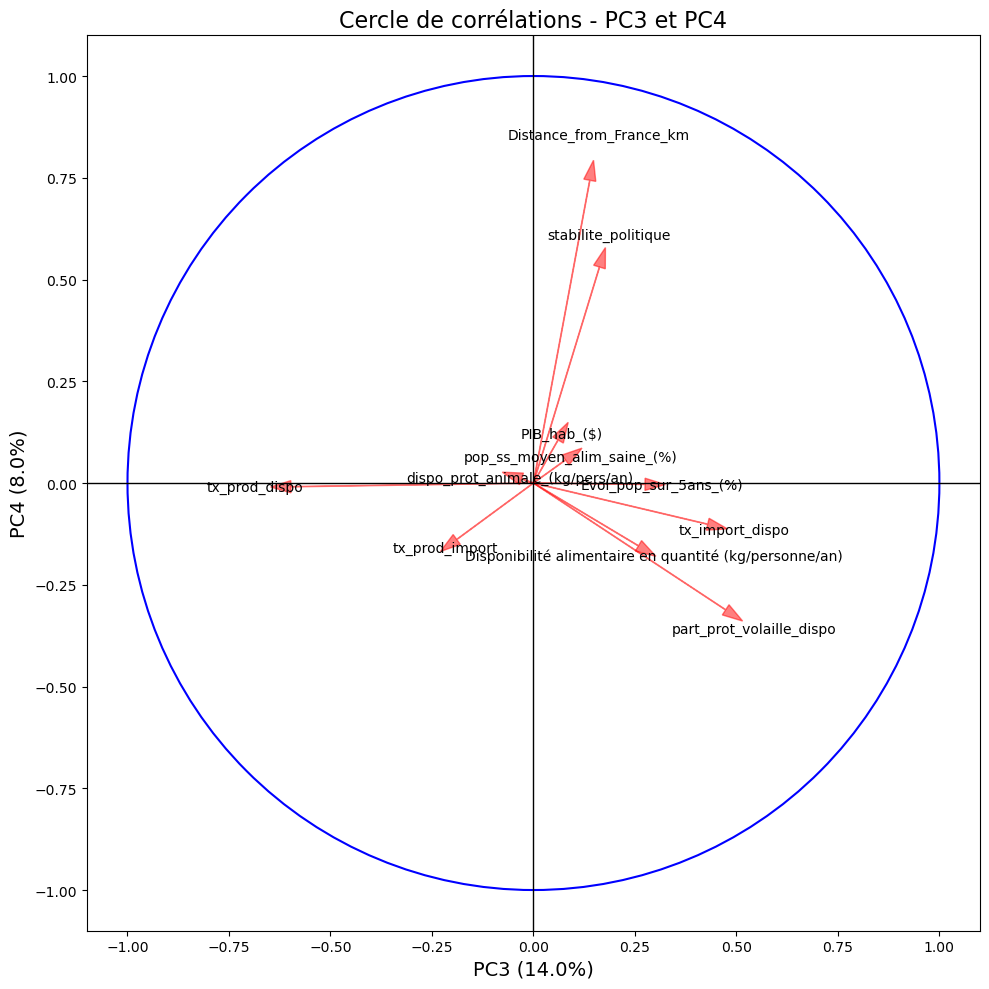

Cos² des variables sur PC3:
Evol_pop_sur_5ans_(%)                                     0.399239
Disponibilité alimentaire en quantité (kg/personne/an)    0.175813
stabilite_politique                                       0.057609
PIB_hab_($)                                               0.020098
pop_ss_moyen_alim_saine_(%)                               0.028342
Distance_from_France_km                                   0.024746
dispo_prot_animale_(kg/pers/an)                           0.003943
tx_prod_dispo                                             0.871243
tx_import_dispo                                           0.469313
tx_prod_import                                            0.173362
part_prot_volaille_dispo                                  0.399694
dtype: float64

Cos² des variables sur PC4:
Evol_pop_sur_5ans_(%)                                     0.000052
Disponibilité alimentaire en quantité (kg/personne/an)    0.062594
stabilite_politique                                      

In [21]:

# Sélectionner les composantes 3 et 4
pc3 = pcs.iloc[2, :]  # Troisième composante principale
pc4 = pcs.iloc[3, :]  # Quatrième composante principale

# Tracer le cercle de corrélations pour PC3 et PC4
fig, ax = plt.subplots(figsize=(10, 10))

# Tracer un cercle unité
circle = Circle((0, 0), 1, facecolor='none', edgecolor='b', lw=1.5)
ax.add_patch(circle)

# Ajouter les flèches représentant les variables dans l'espace des PC3 et PC4
for i in range(len(pc3)):
    ax.arrow(0, 0, pc3[i], pc4[i], color='r', alpha=0.5, head_width=0.03, head_length=0.05)
    ax.text(pc3[i] * 1.15, pc4[i] * 1.15, pcs.columns[i], color='black', ha='center', va='center', fontsize=10)

# Pourcentages de variance expliquée
variance_pc3 = 14.0  # Pourcentage de variance expliquée pour PC3
variance_pc4 = 8.0  # Pourcentage de variance expliquée pour PC4

# Ajouter des lignes pour les axes
plt.axhline(0, color='black', lw=1)
plt.axvline(0, color='black', lw=1)

# Ajouter les limites et le titre
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_xlabel(f'PC3 ({variance_pc3:.1f}%)', fontsize=14)
ax.set_ylabel(f'PC4 ({variance_pc4:.1f}%)', fontsize=14)
plt.title('Cercle de corrélations - PC3 et PC4', fontsize=16)

# Améliorer l'espacement
plt.tight_layout()
plt.show()

# Calculer la somme des carrés des coordonnées pour chaque variable (norme au carré)
norm_squared = pcs.apply(lambda x: x**2, axis=0).sum()

# Calculer le cos² pour PC3 et PC4
cos2_pc3 = (pcs.iloc[2, :]**2) / norm_squared
cos2_pc4 = (pcs.iloc[3, :]**2) / norm_squared

# Afficher les résultats
print("Cos² des variables sur PC3:")
print(cos2_pc3)
print("\nCos² des variables sur PC4:")
print(cos2_pc4)

## <font>3. Projection des individus<a class="anchor" id="1_3"></a></font>

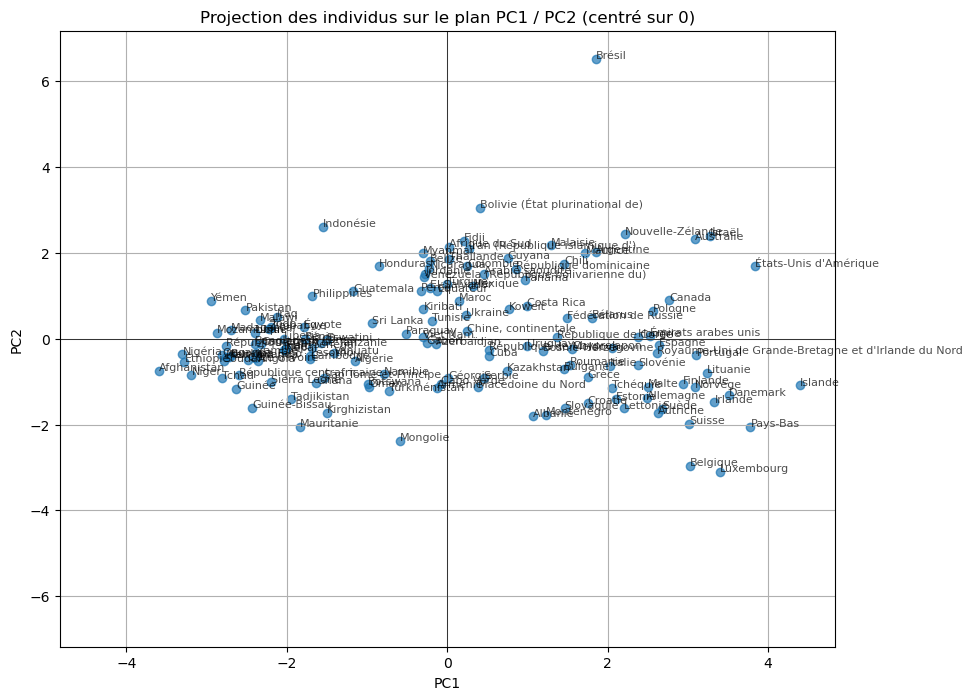

In [22]:
# Normaliser les données complètes si nécessaire
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_complet.select_dtypes(include=[np.number]))


# Sélection des deux premières composantes pour les individus
individuals_pc1_pc2 = pca_result[:, :2]

# Création du scatter plot pour la projection des individus sur PC1 et PC2
plt.figure(figsize=(10, 8))
plt.scatter(individuals_pc1_pc2[:, 0], individuals_pc1_pc2[:, 1], alpha=0.7)

# Calcul des limites des axes pour centrer sur 0
x_lim = np.max(np.abs(individuals_pc1_pc2[:, 0])) * 1.1
y_lim = np.max(np.abs(individuals_pc1_pc2[:, 1])) * 1.1

plt.xlim(-x_lim, x_lim)
plt.ylim(-y_lim, y_lim)

plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

plt.title('Projection des individus sur le plan PC1 / PC2 (centré sur 0)')
plt.xlabel('PC1')
plt.ylabel('PC2')

# Afficher les labels des individus
for i, label in enumerate(df_complet['zone']):
    plt.text(individuals_pc1_pc2[i, 0], individuals_pc1_pc2[i, 1], label, fontsize=8, alpha=0.7)

plt.grid(True)
plt.show()



# Analyse de la Projection des Individus sur le Plan PC1 / PC2

Cette projection des pays sur le plan défini par les deux premières composantes principales (PC1 et PC2) permet de mieux comprendre la segmentation des pays en fonction des indicateurs économiques et alimentaires.

## Interprétation de PC1 (axe horizontal)

PC1 capture principalement des variables économiques comme le PIB par habitant et la disponibilité alimentaire, avec une corrélation positive forte pour les pays riches et bien approvisionnés en protéines animales, et une corrélation négative pour les pays où la population sous-alimentée est élevée :

- **Pays situés à droite du graphique** : 
    - Les pays comme les **Pays-Bas**, le **Luxembourg**, et la **Belgique** ont un **PIB par habitant élevé** et une bonne **disponibilité en protéines animales**. Cela reflète une économie stable avec des ressources alimentaires abondantes.
    - Ces pays peuvent cependant représenter des marchés plus compétitifs pour l'exportation de nouveaux produits comme le poulet bio, étant donné qu'ils sont déjà bien pourvus en offres alimentaires.

- **Pays situés à gauche du graphique** :
    - Des pays comme l'**Afghanistan**, l'**Éthiopie**, et le **Soudan** sont caractérisés par une **forte proportion de population sous-alimentée** et un **PIB plus faible**. Leur position sur PC1 indique une plus grande vulnérabilité alimentaire.
    - Ces pays pourraient avoir des difficultés à être des marchés viables pour des produits premium comme le poulet bio.

## Interprétation de PC2 (axe vertical)

PC2 capture des variables liées aux **échanges alimentaires** et à la **production importée**. Il permet d’identifier les pays où la dépendance à l’importation ou l’exportation de produits alimentaires est importante :

- **Pays situés en haut du graphique** :
    - Le **Brésil** se distingue par une **forte production alimentaire exportée**, particulièrement dans le domaine de la volaille. Cela en fait un pays déjà très bien positionné dans le commerce alimentaire international, mais potentiellement concurrent pour l'exportation de poulet bio.
  
- **Pays situés en bas du graphique** :
    - Les pays comme la **Mongolie** ou le **Yémen** sont plus **dépendants des importations alimentaires**. Ces marchés peuvent être intéressants pour l'introduction de produits alimentaires d'importation comme le poulet bio, bien qu'ils soient plus fragiles économiquement.

## Analyse des Pays Spécifiques

- **Brésil** : Situé très haut sur PC2, le Brésil est un important exportateur alimentaire. Bien que ce marché soit déjà saturé en volaille, il pourrait être intéressant pour de nouvelles gammes de produits biologiques, selon la demande interne.
  
- **Bolivie**, **Israël**, **Nouvelle-Zélande** : Ces pays, proches du centre du graphique, présentent un équilibre entre **production et importation** de produits alimentaires. Ils pourraient représenter des opportunités intéressantes pour l'exportation de poulet bio, dans des marchés moins saturés que ceux de l'Europe ou des États-Unis.

- **Pays européens riches** : Les **Pays-Bas**, **Luxembourg**, **Belgique** et d'autres pays européens de l’Ouest sont économiquement prospères avec une bonne disponibilité alimentaire. Cependant, ces marchés sont très compétitifs pour de nouveaux produits alimentaires, rendant l'entrée plus difficile.

- **Pays en développement (Afrique et Asie)** : Les pays comme l'**Afghanistan**, le **Soudan**, et le **Pakistan** sont vulnérables sur le plan alimentaire avec une **forte sous-alimentation**. Ils pourraient ne pas être des marchés viables pour des produits premium comme le poulet bio en raison de leur faible pouvoir d'achat.





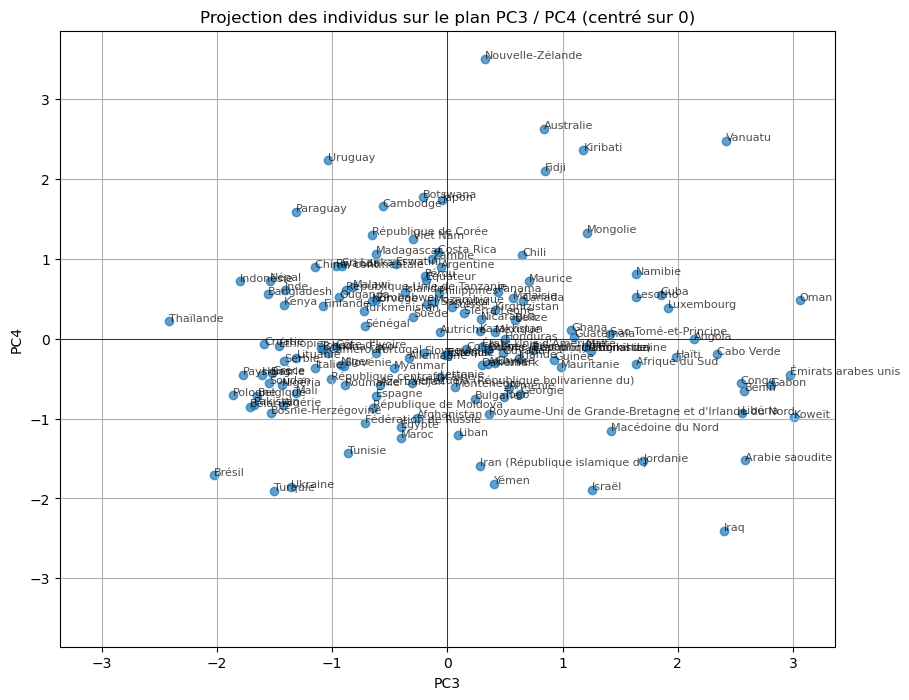

In [23]:
# Normaliser les données complètes si nécessaire
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_complet.select_dtypes(include=[np.number]))

# Recalculer la PCA avec toutes les variables
pca = PCA()
pca_result = pca.fit_transform(X_scaled)

# Sélection des composantes PC3 et PC4 pour les individus
individuals_pc3_pc4 = pca_result[:, 2:4]

# Création du scatter plot pour la projection des individus sur PC3 et PC4
plt.figure(figsize=(10, 8))
plt.scatter(individuals_pc3_pc4[:, 0], individuals_pc3_pc4[:, 1], alpha=0.7)

# Calcul des limites des axes pour centrer sur 0
x_lim = np.max(np.abs(individuals_pc3_pc4[:, 0])) * 1.1
y_lim = np.max(np.abs(individuals_pc3_pc4[:, 1])) * 1.1

plt.xlim(-x_lim, x_lim)
plt.ylim(-y_lim, y_lim)

plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

plt.title('Projection des individus sur le plan PC3 / PC4 (centré sur 0)')
plt.xlabel('PC3')
plt.ylabel('PC4')

# Afficher les labels des individus
for i, label in enumerate(df_complet['zone']):
    plt.text(individuals_pc3_pc4[i, 0], individuals_pc3_pc4[i, 1], label, fontsize=8, alpha=0.7)

plt.grid(True)
plt.show()




## <font>4. Heatmap des composantes principales<a class="anchor" id="1_4"></a></font>

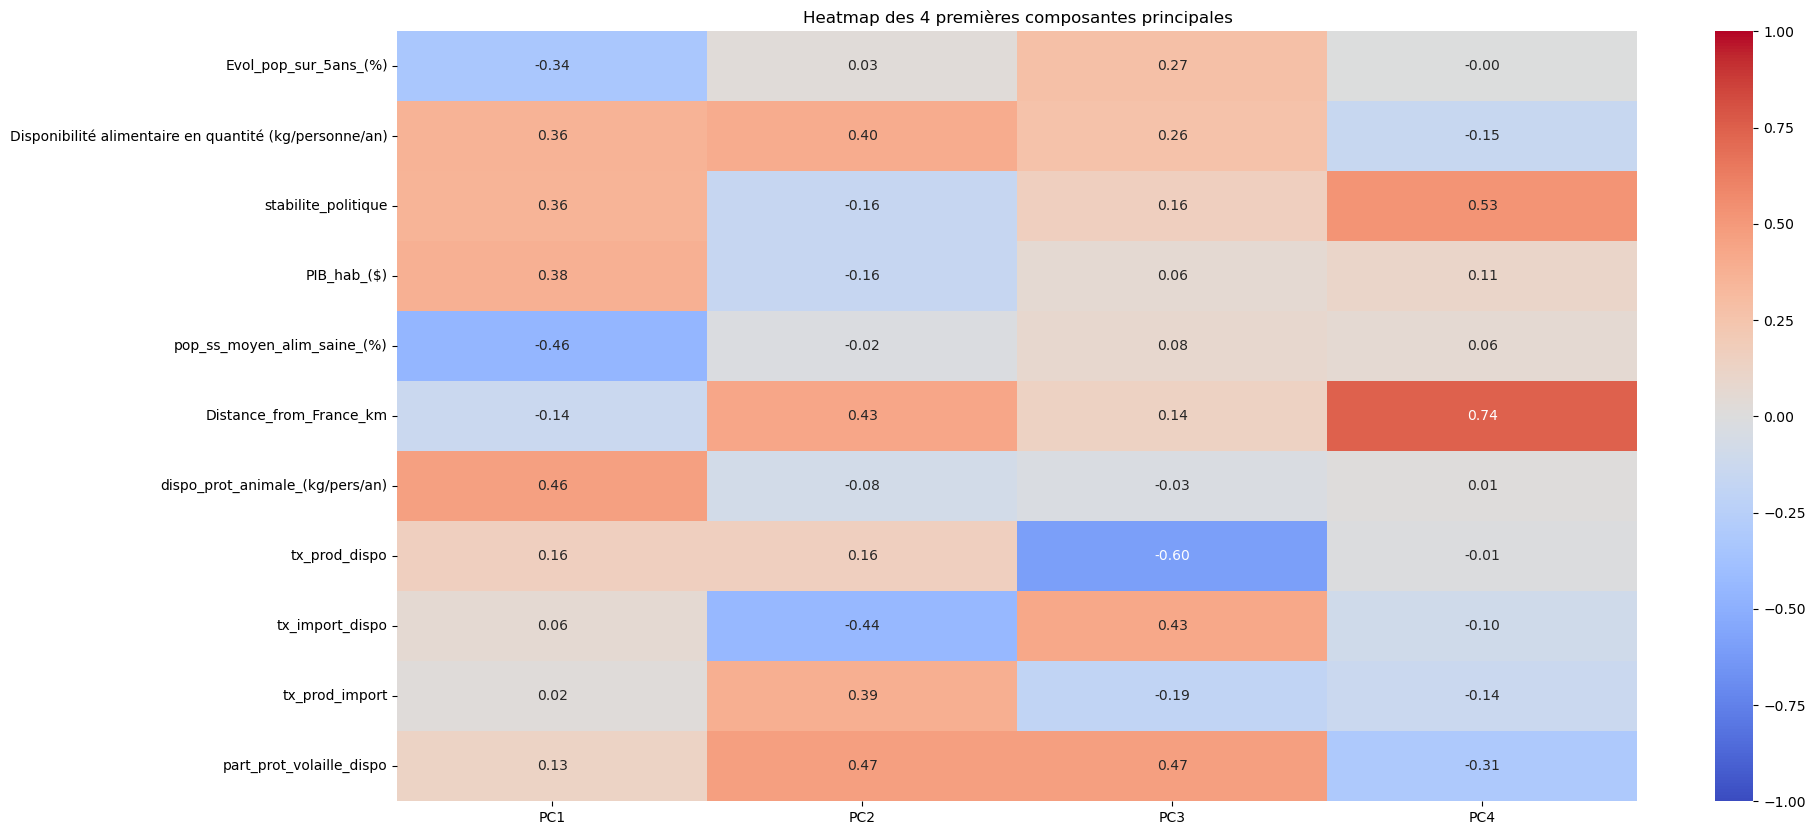

In [24]:
# Appliquer les colonnes et les index à 'pcs'
pcs.columns = features  # Colonnes des variables
pcs.index = [f"PC{i}" for i in range(1, n_components+1)]  # Index des composantes principales



# Afficher les premières composantes sous forme de heatmap
fig, ax = plt.subplots(figsize=(20, 10))

sns.heatmap(pcs.T.iloc[:,:6], vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Heatmap des 4 premières composantes principales')
plt.show()

# Analyse de la Heatmap des 4 premières composantes principales

Cette heatmap met en évidence la contribution des différentes variables aux quatre premières composantes principales (PC1, PC2, PC3, et PC4).

## PC1 (Composante Principale 1)
PC1 est fortement influencée par des variables économiques et alimentaires :
- **PIB par habitant** (0.38) et **disponibilité en protéines animales** (0.46) sont des contributeurs majeurs positifs.
- **Proportion de la population sous-alimentée** (-0.46) est corrélée négativement avec PC1.
Cela montre que PC1 capture principalement des facteurs de stabilité économique et de bien-être alimentaire.

## PC2 (Composante Principale 2)
PC2 est dominée par des variables liées à l’échange et à la production alimentaire :
- **Part de protéines volaille disponibles** (0.47) et **taux d'importation** (-0.44) sont des contributeurs significatifs.
PC2 semble donc capturer des aspects d'importation alimentaire et la disponibilité en protéines volaille.

## PC3 (Composante Principale 3)
PC3 est influencée par des variables géographiques et d’import-export :
- **Distance de la France** (0.74) et **taux d'importation** (0.43) sont les facteurs les plus importants pour cette composante.
Cela indique que PC3 capture des aspects liés à la distance géographique et aux échanges internationaux.

## PC4 (Composante Principale 4)
PC4 est moins influencée par les variables majeures, mais la **stabilité politique** (0.33) et **Distance de la France** (0.24) ont des contributions relativement importantes. Cela suggère que PC4 reflète des dimensions plus spécifiques et moins dominantes dans les données.

En résumé, PC1 se concentre sur les aspects économiques et alimentaires, PC2 sur les échanges alimentaires





# <font color='blue'>Partie 4 - Clustering CAH<a class="anchor" id="partie4"></a></font>

## <font>1. Dendogramme<a class="anchor" id="4_1"></a></font>

In [25]:
# Sélection des variables pertinentes
variables_to_use = ['Evol_pop_sur_5ans_(%)',
                    'Disponibilité alimentaire en quantité (kg/personne/an)',
                    'stabilite_politique',
                    'PIB_hab_($)',
                    'pop_ss_moyen_alim_saine_(%)',
                    'Distance_from_France_km',
                    'dispo_prot_animale_(kg/pers/an)',
                    'tx_prod_dispo',
                    'tx_import_dispo',
                    'tx_prod_import',
                    'part_prot_volaille_dispo']

# Filtrer les données
X = df_complet[variables_to_use]

# Standardiser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [26]:
# Calcul des distances entre les individus
dist_matrix = pdist(X_scaled, metric='euclidean')


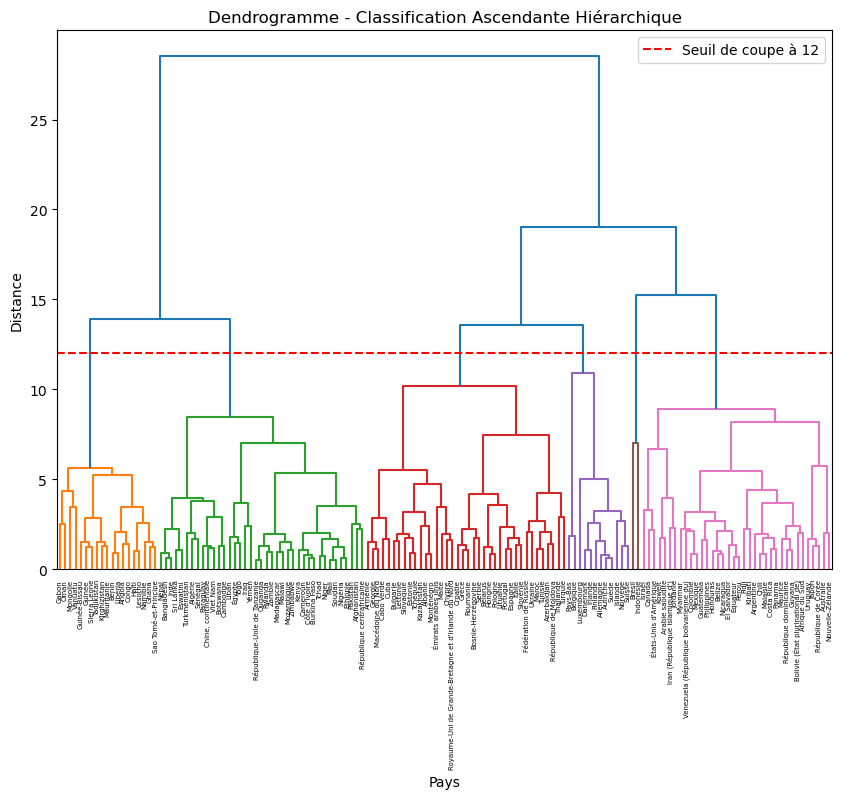

In [27]:
# Calcul des liens hiérarchiques (utilisation de la méthode 'ward')
Z = linkage(dist_matrix, method='ward')

# Tracer le dendrogramme
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=df_complet['zone'].values, color_threshold=12)
plt.title('Dendrogramme - Classification Ascendante Hiérarchique')
plt.xlabel('Pays')
plt.ylabel('Distance')

# Ajouter une ligne horizontale pour indiquer le seuil de coupe
plt.axhline(y=12, color='r', linestyle='--', label='Seuil de coupe à 12')

plt.legend()  # Afficher la légende pour la ligne
plt.show()



Ce dendrogramme est issu d'une **Classification Ascendante Hiérarchique (CAH)** avec un seuil de coupe à 12, ce qui permet d'obtenir 6 clusters distincts.


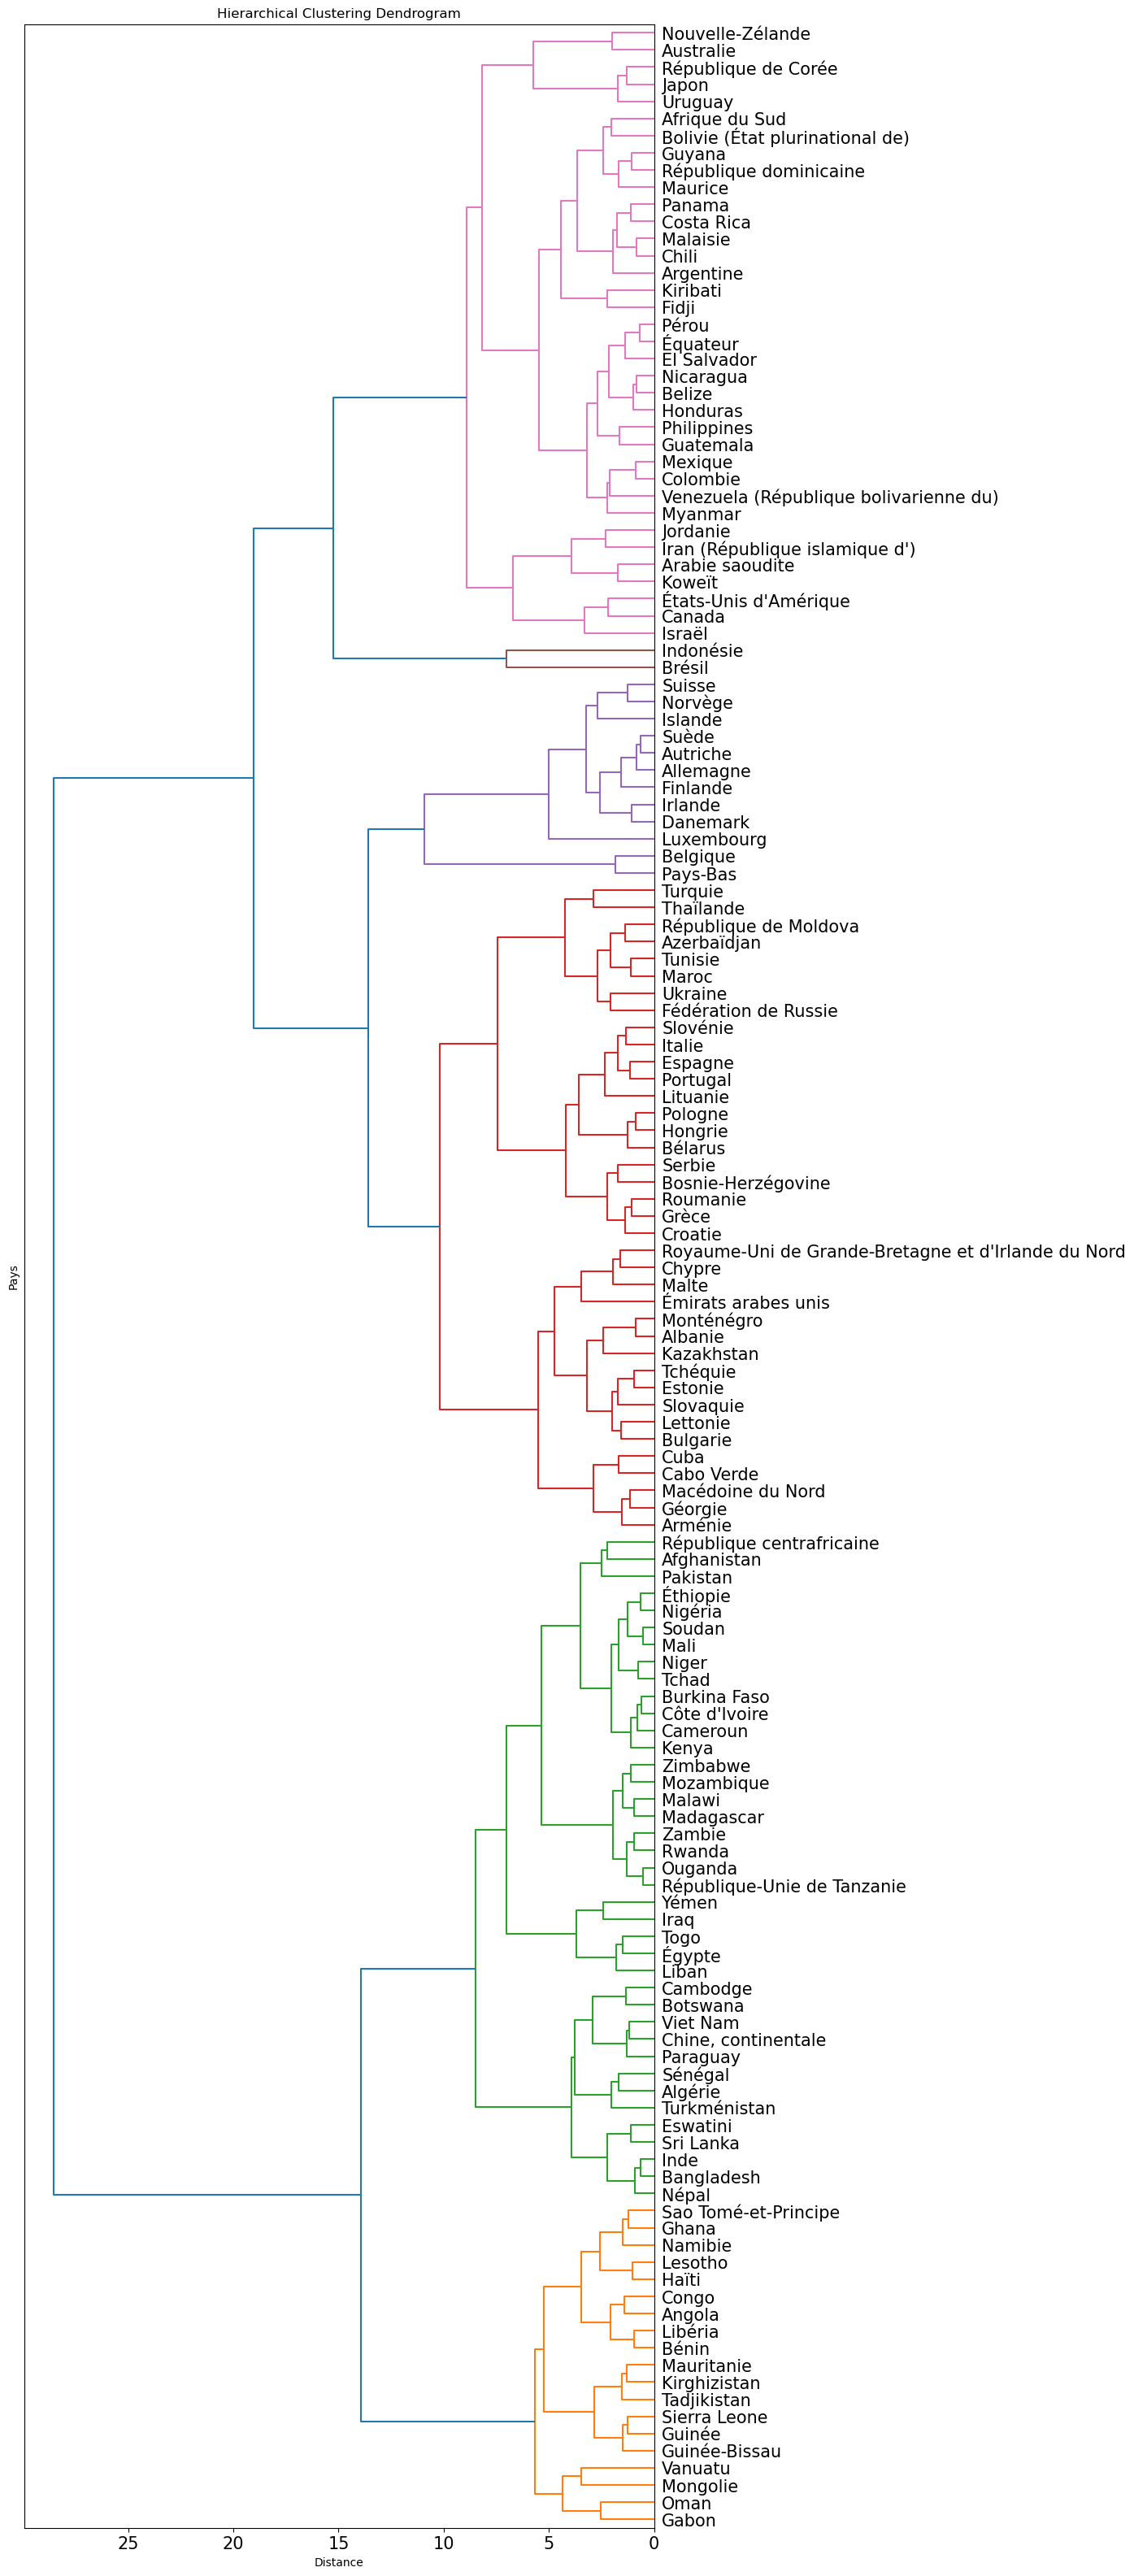

In [28]:
# Affichage du dendrogramme
fig, ax = plt.subplots(1, 1, figsize=(10,40))

# matérialisation des clusters à partir de la hauteur = 12
dendrogram_left = dendrogram(Z, ax=ax, labels=names,orientation='left', color_threshold=12) 
plt.title("Hierarchical Clustering Dendrogram")
ax.set_xlabel("Distance")
ax.set_ylabel("Pays")
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=15)


In [29]:
# Définir le nombre de clusters souhaité
num_clusters = 6

# Découper le dendrogramme pour obtenir les clusters
clusters = fcluster(Z, num_clusters, criterion='maxclust')

# Ajouter l'information des clusters au dataframe
df_complet['Cluster'] = clusters

## <font>2. Analyse des clusters<a class="anchor" id="4_2"></a></font>

In [30]:
# Afficher le nombre de pays par cluster
print(df_complet['Cluster'].value_counts())

# Afficher les pays dans chaque cluster
for cluster_num in range(1, num_clusters+1):
    print(f"\nCluster {cluster_num}:")
    print(df_complet[df_complet['Cluster'] == cluster_num]['zone'].values)


Cluster
2    39
3    38
6    36
1    19
4    12
5     2
Name: count, dtype: int64

Cluster 1:
['Angola' 'Congo' 'Bénin' 'Gabon' 'Ghana' 'Guinée' 'Haïti' 'Kirghizistan'
 'Lesotho' 'Libéria' 'Mauritanie' 'Mongolie' 'Namibie' 'Vanuatu'
 'Guinée-Bissau' 'Sao Tomé-et-Principe' 'Sierra Leone' 'Tadjikistan'
 'Oman']

Cluster 2:
['Afghanistan' 'Algérie' 'Bangladesh' 'Botswana' 'Cameroun'
 'République centrafricaine' 'Sri Lanka' 'Tchad' 'Chine, continentale'
 'Égypte' 'Inde' 'Iraq' "Côte d'Ivoire" 'Kenya' 'Cambodge' 'Liban'
 'Madagascar' 'Malawi' 'Mali' 'Mozambique' 'Népal' 'Niger' 'Nigéria'
 'Pakistan' 'Paraguay' 'Zimbabwe' 'Rwanda' 'Sénégal' 'Eswatini'
 'Turkménistan' 'République-Unie de Tanzanie' 'Togo' 'Ouganda'
 'Burkina Faso' 'Viet Nam' 'Éthiopie' 'Yémen' 'Zambie' 'Soudan']

Cluster 3:
['Arménie' 'Albanie' 'Bulgarie' 'Cabo Verde' 'Cuba' 'Chypre' 'Azerbaïdjan'
 'Bélarus' 'Estonie' 'Géorgie' 'Bosnie-Herzégovine' 'Grèce' 'Hongrie'
 'Croatie' 'Italie' 'Kazakhstan' 'Lettonie' 'Lituanie' 'Malte

In [31]:
# Sélectionner uniquement les colonnes numériques
numeric_columns = df_complet.select_dtypes(include=[np.number]).columns
df_numeric = df_complet[numeric_columns]

# Résumé des clusters uniquement pour les colonnes numériques
cluster_summary = df_numeric.groupby(df_complet['Cluster']).mean()
print(cluster_summary)

# Exporter le cluster_summary en CSV
cluster_summary.to_csv('cluster_summary.csv', index=False, encoding='utf-8')

         Evol_pop_sur_5ans_(%)  \
Cluster                          
1                    11.667368   
2                    10.556923   
3                     0.530526   
4                     3.671667   
5                     5.115000   
6                     6.121111   

         Disponibilité alimentaire en quantité (kg/personne/an)  \
Cluster                                                           
1                                                10.027895        
2                                                 4.515897        
3                                                21.407632        
4                                                20.321667        
5                                                27.610000        
6                                                30.923611        

         stabilite_politique   PIB_hab_($)  pop_ss_moyen_alim_saine_(%)  \
Cluster                                                                   
1                  -0.102105   2991.6147

# Analyse des Clusters CAH 

## Cluster 1 (19 pays)
- **Évolution de la population** : 11.67%, la plus élevée parmi les clusters.
- **Disponibilité alimentaire** : Faible, à 10.03 kg/personne/an.
- **PIB par habitant** : Très faible (2 991 $).
- **Population sous-alimentée** : Relativement élevée (73.48%).
- **Protéines animales disponibles** : 8.02 kg/personne/an, parmi les plus faibles.
- **Pays** : Angola, Congo, Bénin, Gabon, Ghana, Haïti, etc.

### Analyse :
Ce cluster regroupe des pays à faible PIB, forte croissance démographique et une alimentation encore limitée. Ces pays pourraient représenter un potentiel en termes de volume à cause de leur croissance, mais leur pouvoir d'achat et leurs infrastructures restent des freins.

## Cluster 2 (39 pays)
- **Évolution de la population** : 10.56%.
- **Disponibilité alimentaire** : Très faible (4.52 kg/personne/an).
- **PIB par habitant** : Faible (2 314 $).
- **Protéines animales disponibles** : 6.29 kg/personne/an, la plus faible.
- **Pays** : Afghanistan, Algérie, Bangladesh, Chine continentale, Égypte, Inde, etc.

### Analyse :
Ce cluster regroupe des pays à forte population et faible disponibilité alimentaire. Les opportunités sont liées à la demande alimentaire croissante, mais la disponibilité des protéines animales est très faible.

## Cluster 3 (38 pays)
- **Évolution de la population** : Faible (0.53%).
- **Disponibilité alimentaire** : Modérée (21.41 kg/personne/an).
- **PIB par habitant** : Moyen (13 516 $).
- **Protéines animales disponibles** : 17.39 kg/personne/an.
- **Pays** : Arménie, Bulgarie, Croatie, Espagne, Portugal, Turquie, etc.

### Analyse :
Ce cluster regroupe des pays européens et asiatiques avec une population relativement stable, une disponibilité modérée d'aliments, et des revenus moyens. Ces pays peuvent être intéressants pour exporter des produits premium comme le poulet bio.

## Cluster 4 (12 pays)
- **Évolution de la population** : 3.67%.
- **Disponibilité alimentaire** : Très élevée (20.32 kg/personne/an).
- **PIB par habitant** : Très élevé (62 859 $).
- **Population sous-alimentée** : Presque inexistante (0.29%).
- **Protéines animales disponibles** : 24.95 kg/personne/an, la plus élevée.
- **Pays** : Autriche, Danemark, Allemagne, Pays-Bas, Norvège, etc.

### Analyse :
Ce cluster regroupe des pays développés européens avec un fort pouvoir d'achat et une très bonne stabilité alimentaire. Ces pays représentent un marché idéal pour des produits premium comme le poulet bio.

## Cluster 5 (2 pays)
- **Évolution de la population** : 5.12%.
- **Disponibilité alimentaire** : Très élevée (27.61 kg/personne/an).
- **PIB par habitant** : Moyen (6 868 $).
- **Protéines animales disponibles** : 13.69 kg/personne/an.
- **Pays** : Brésil, Indonésie.

### Analyse :
Bien que ce cluster ne comporte que 2 pays, ces pays (Brésil et Indonésie) présentent une grande disponibilité alimentaire et une production animale importante. Ils peuvent être des concurrents pour l'exportation.

## Cluster 6 (36 pays)
- **Évolution de la population** : 6.12%.
- **Disponibilité alimentaire** : Très élevée (30.92 kg/personne/an).
- **PIB par habitant** : Élevé (15 708 $).
- **Protéines animales disponibles** : 14.56 kg/personne/an.
- **Pays** : Argentine, Australie, Canada, Japon, États-Unis, Israël, etc.

### Analyse :
Ce cluster regroupe des pays à haut pouvoir d'achat avec une grande disponibilité alimentaire. Ils peuvent représenter un excellent marché pour l'exportation de produits bio, bien que ces pays puissent déjà avoir une production locale importante.

## Conclusion générale
Les clusters 4 et 6 représentent les meilleures opportunités d'exportation de poulet bio en raison du pouvoir d'achat élevé et de la forte demande en produits premium. Les clusters 1 et 2 présentent des opportunités de croissance à long terme, mais les infrastructures et le pouvoir d'achat peuvent limiter les possibilités immédiates.



## <font>3. Heatmap des clusters<a class="anchor" id="4_3"></a></font>

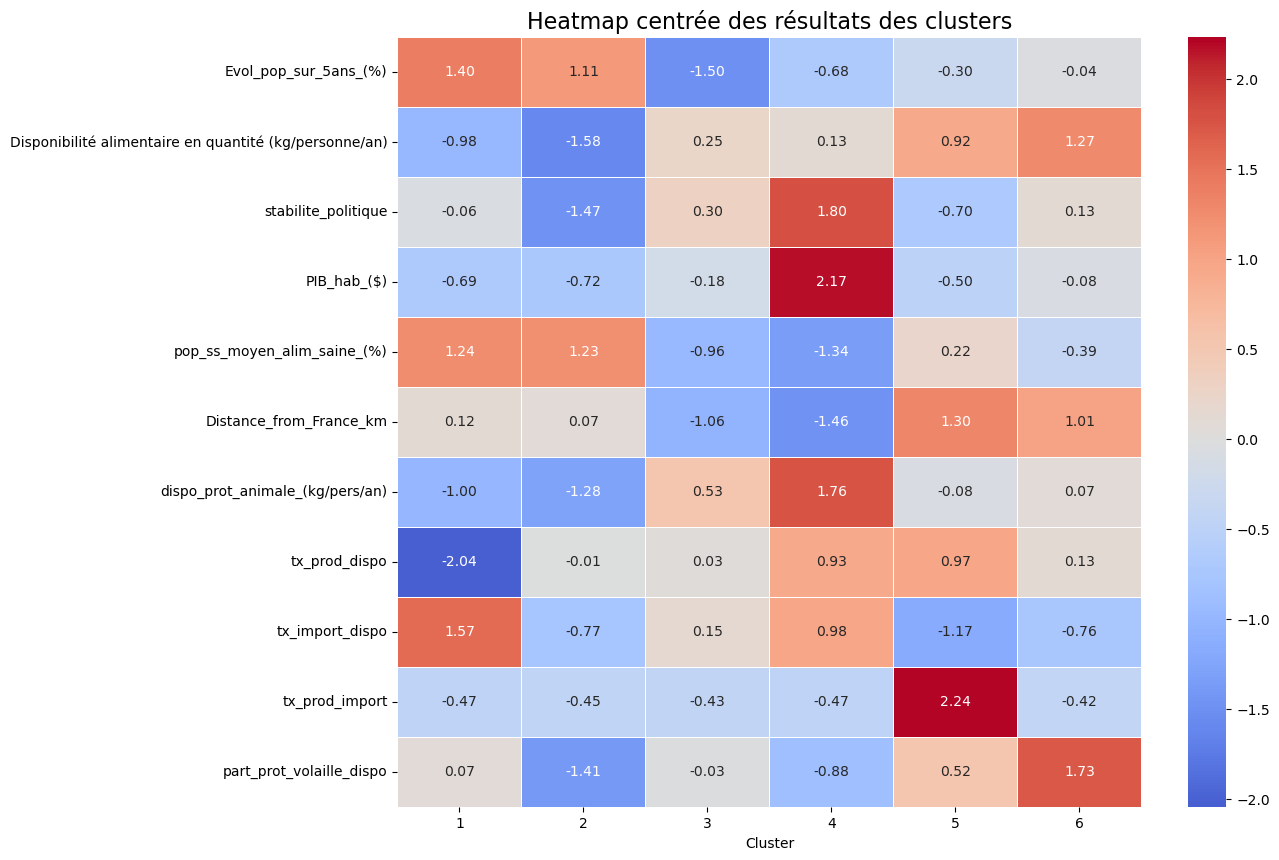

In [32]:
# Exclure la colonne 'Cluster' des variables à centrer et réduire
cluster_summary_excluded = cluster_summary.drop(columns=['Cluster'])

# Centrer et réduire les résultats des clusters
scaler = StandardScaler()
cluster_summary_scaled = scaler.fit_transform(cluster_summary_excluded)

# Convertir en DataFrame pour garder les noms de colonnes et d'index
cluster_summary_scaled_df = pd.DataFrame(cluster_summary_scaled, 
                                         index=cluster_summary.index, 
                                         columns=cluster_summary_excluded.columns)

# Créer une heatmap pour visualiser les résultats des clusters centrés-réduits, avec les axes inversés
plt.figure(figsize=(12, 10))  
sns.heatmap(cluster_summary_scaled_df.T, annot=True, cmap="coolwarm", center=0, fmt=".2f", linewidths=.5)

# Ajouter un titre
plt.title("Heatmap centrée des résultats des clusters", fontsize=16)

# Afficher la heatmap
plt.show()

# Analyse de la Heatmap des Clusters

## Cluster 1
- **Croissance de la population** : Élevée (+1.40).
- **Disponibilité alimentaire** : Faible (-0.98).
- **Taux de production** : Très faible (-2.04).
- **Taux d'importation** : Élevé (+1.57).

### Analyse :
Pays en développement avec une forte croissance démographique, mais des infrastructures alimentaires limitées. Leur dépendance aux importations suggère des opportunités pour des exportations alimentaires, mais avec des contraintes économiques.

## Cluster 2
- **Disponibilité alimentaire** : Très faible (-1.58).
- **PIB par habitant** : Faible (-0.72).
- **Protéines animales disponibles** : Très faible (-1.28).
- **Stabilité politique** : Faible (-1.47).

### Analyse :
Ce cluster regroupe des pays avec des difficultés économiques et alimentaires significatives. La stabilité politique limitée et la faible disponibilité de protéines animales montrent des pays en grande difficulté.

## Cluster 3
- **PIB par habitant** : Élevé (+2.17).
- **Stabilité politique** : Élevée (+1.80).
- **Disponibilité alimentaire** : Modérée (+0.13).

### Analyse :
Ce cluster inclut des pays à forte stabilité politique et économique, idéaux pour des produits premium, tels que le poulet bio. Ces pays pourraient être des marchés viables pour des exportations à plus forte valeur ajoutée.

## Cluster 4
- **Taux d'importation** : Très élevé (+2.24).
- **Disponibilité alimentaire** : Élevée (+1.30).
- **Distance de la France** : Proche (-1.46).

### Analyse :
Pays ayant un fort besoin d'importation alimentaire avec une disponibilité alimentaire déjà élevée. Ce cluster représente un potentiel important pour les exportations alimentaires, notamment dans des pays géographiquement plus proches de la France.

## Cluster 5
- **Taux d'importation** : Modéré (+0.98).
- **Croissance modérée** : (+0.91).
- **Part des protéines volaille disponibles** : Élevée (+1.73).

### Analyse :
Ce cluster est intéressant pour les exportations de produits spécifiques comme le poulet bio. Bien que la croissance soit modérée, la disponibilité des protéines animales est un signe d’un marché déjà structuré.

## Cluster 6
- **Disponibilité alimentaire** : Très élevée (+1.27).
- **Taux de production** : Modéré (+0.14).
- **Part des protéines volaille disponibles** : Très élevée (+1.73).

### Analyse :
Ce groupe est constitué de pays ayant une forte disponibilité alimentaire, avec un potentiel commercial élevé pour l'exportation. Leur production locale est aussi modérée, ce qui pourrait offrir des opportunités d'importation pour des produits spécifiques comme le poulet bio.




## <font>4. Radar charts<a class="anchor" id="4_4"></a></font>

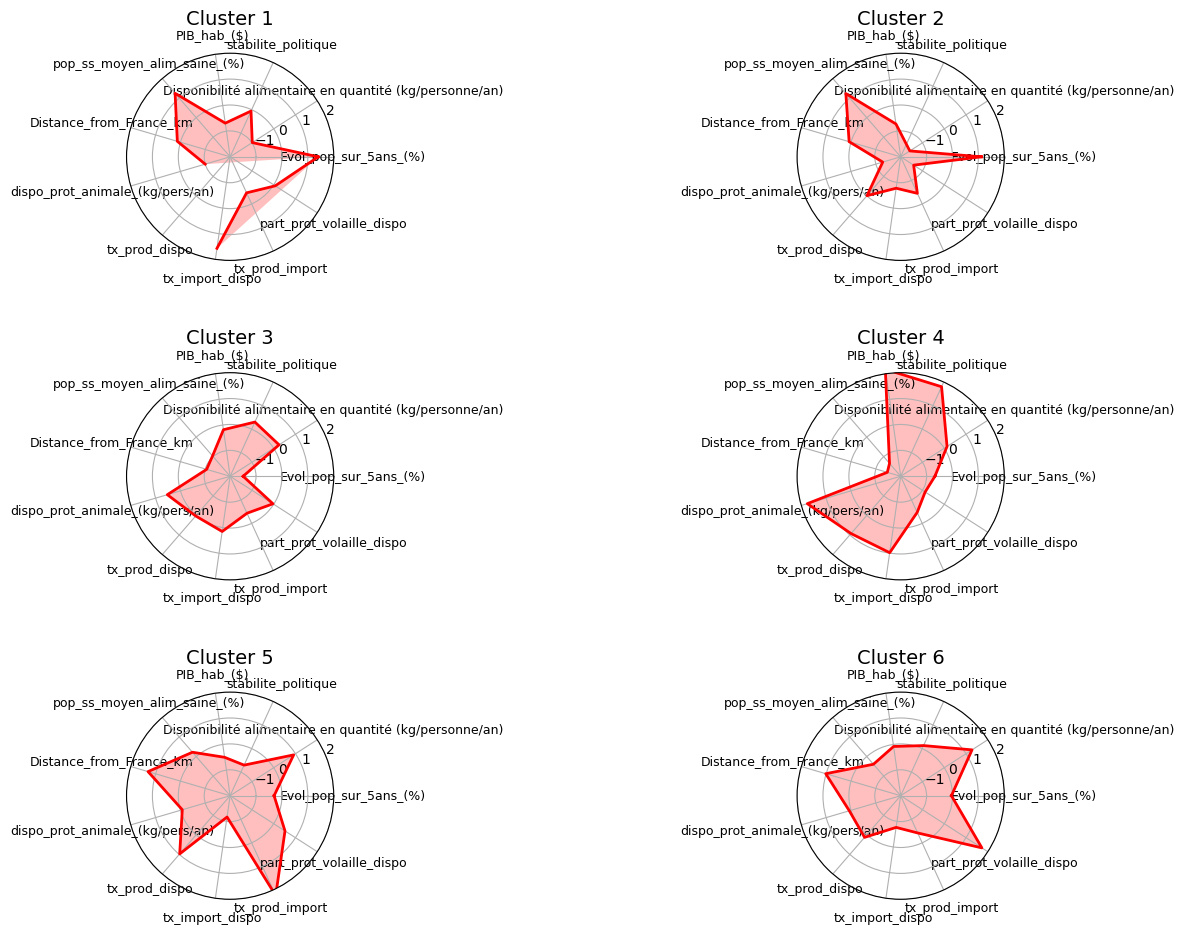

In [33]:
# Fonction pour créer un radar chart
def radar_chart(ax, data, variables, cluster_num):
    # Nombre de variables
    num_vars = len(variables)
    
    # Créer les angles pour chaque variable
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # Fermer le graphique sur lui-même
    data = np.concatenate((data,[data[0]]))
    angles += angles[:1]

    # Tracer le graphique
    ax.fill(angles, data, color='red', alpha=0.25)
    ax.plot(angles, data, color='red', linewidth=2)

    # Ajuster les étiquettes des axes
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(variables, fontsize=9)  # Réduire la taille des labels

    # Ajouter un titre
    ax.set_title(f'Cluster {cluster_num}', size=14, color='black', y=1.1)
    
    # Ajuster les limites du graphique
    ax.set_ylim(-2, 2)

    # Ajouter une grille plus claire
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)

# Créer les sous-graphiques avec 2 colonnes
num_clusters = len(cluster_summary_scaled_df.index)
fig, axes = plt.subplots(nrows=(num_clusters + 1) // 2, ncols=2, figsize=(14, 10), subplot_kw=dict(polar=True))

# Parcourir chaque cluster pour afficher les radar charts
for i, cluster_num in enumerate(cluster_summary_scaled_df.index):
    row = i // 2
    col = i % 2
    radar_chart(axes[row, col], 
                cluster_summary_scaled_df.loc[cluster_num].values, 
                cluster_summary_scaled_df.columns, 
                cluster_num)

# Ajuster les espacements entre les sous-graphiques
plt.tight_layout(pad=3.0)
plt.show()

## <font>5. Projection des individus<a class="anchor" id="4_5"></a></font>

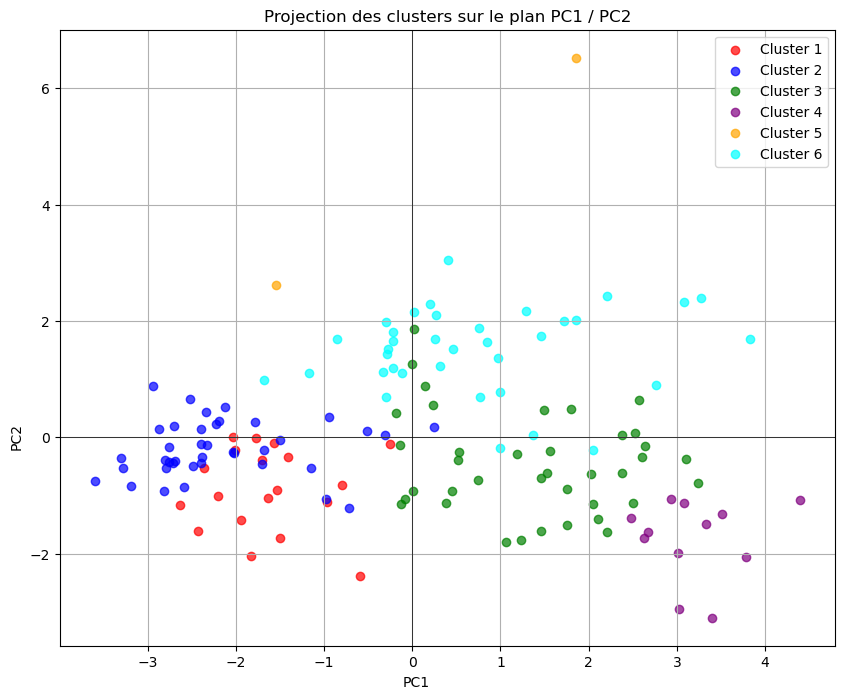

In [34]:
# Ajout des clusters au dataframe des résultats de la PCA
df_complet['Cluster'] = fcluster(Z, t=6, criterion='maxclust')

# Sélection des deux premières composantes principales
plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan'] 
for cluster_num in range(1, 7):  # 6 clusters
    subset = df_complet[df_complet['Cluster'] == cluster_num]
    plt.scatter(pca_result[df_complet['Cluster'] == cluster_num, 0], 
                pca_result[df_complet['Cluster'] == cluster_num, 1], 
                label=f'Cluster {cluster_num}', alpha=0.7, color=colors[cluster_num-1])

plt.xlabel('PC1', x=0.46)
plt.ylabel('PC2', y=0.34)
plt.title('Projection des clusters sur le plan PC1 / PC2')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.legend()
plt.grid(True)
plt.show()


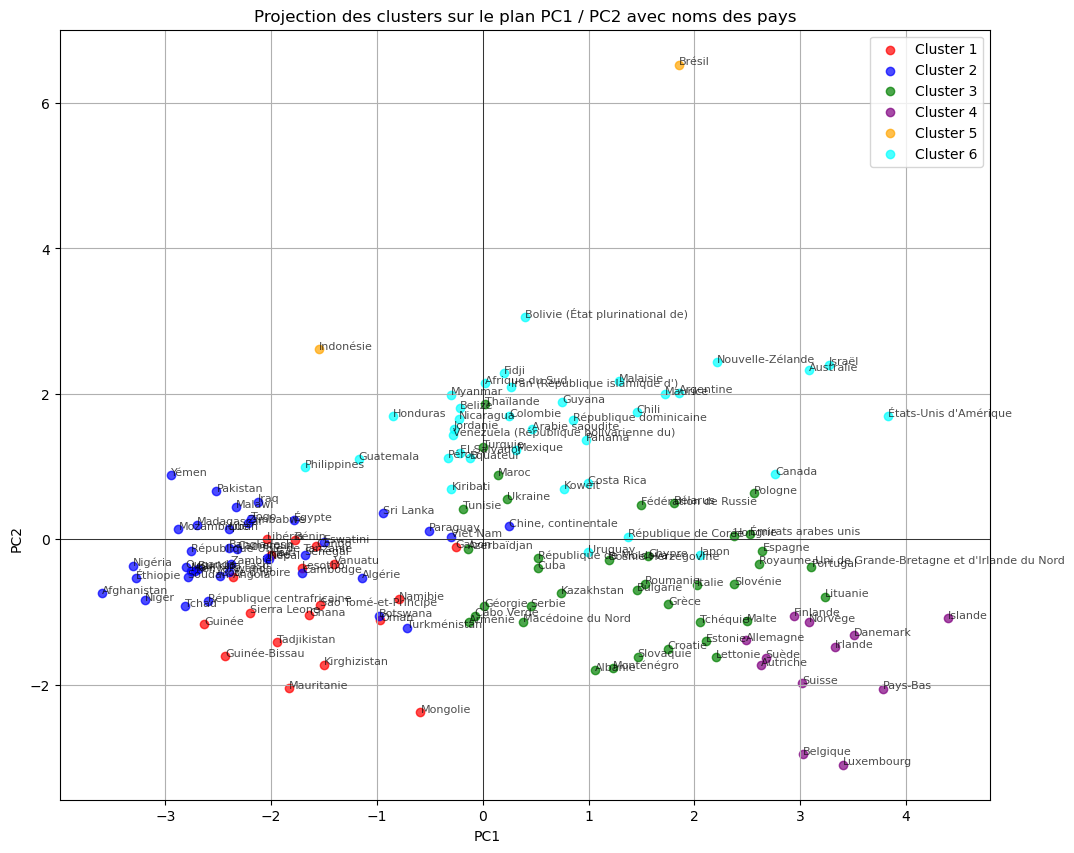

In [35]:
# Sélection des deux premières composantes principales
plt.figure(figsize=(12, 10))
colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan']


for cluster_num in range(1, 7):  # 6 clusters
    subset = df_complet[df_complet['Cluster'] == cluster_num]
    plt.scatter(pca_result[df_complet['Cluster'] == cluster_num, 0], 
                pca_result[df_complet['Cluster'] == cluster_num, 1], 
                label=f'Cluster {cluster_num}', alpha=0.7, color=colors[cluster_num-1])
    
    # Ajout des noms des pays
    for i in subset.index:
        plt.text(pca_result[i, 0], pca_result[i, 1], subset['zone'][i], fontsize=8, alpha=0.7)


# Centrer les labels des axes
plt.xlabel('PC1', x=0.46)
plt.ylabel('PC2', y=0.34)

plt.title('Projection des clusters sur le plan PC1 / PC2 avec noms des pays')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.legend()
plt.grid(True)
plt.show()


# Analyse de la Projection des Individus sur le Plan PC1 / PC2

Cette projection des individus (pays) sur les deux premières composantes principales (PC1 et PC2) permet d'analyser leur positionnement par rapport aux variables économiques, démographiques et alimentaires.

### Cluster 1 (rouge)
- Ce cluster regroupe principalement des **pays à faible PIB et fort taux de sous-alimentation**.
- Ces pays sont positionnés à **gauche du plan**, indiquant un faible PC1, ce qui reflète leur faible développement économique et sous-alimentation.
- Exemple de pays : **Afghanistan, Niger, Guinée-Bissau**.

### Cluster 2 (bleu)
- Ce cluster contient des **pays en développement** avec une **croissance démographique élevée** mais un **PIB encore relativement bas**.
- Ils sont situés à gauche et plus proches du **centre vertical**, ce qui suggère une **légère amélioration dans l’accès aux ressources alimentaires**, bien que des défis persistent.
- Exemple de pays : **Bangladesh, Cameroun, Égypte**.

### Cluster 3 (vert)
- Les pays de ce cluster ont un **PIB plus élevé** et une **disponibilité alimentaire relativement bonne**.
- Ils sont situés à **droite du graphique** (valeurs positives de PC1) et légèrement au-dessus de l’axe de PC2, ce qui indique une **certaine dépendance aux importations alimentaires**.
- Exemple de pays : **Espagne, Maroc, Turquie**.

### Cluster 4 (violet)
- Ce cluster regroupe des **pays économiquement stables avec un PIB élevé** et une **bonne stabilité politique**.
- Ils sont situés **en bas à droite du graphique**, indiquant une **forte capacité de production locale** avec une **faible dépendance aux importations alimentaires**.
- Exemple de pays : **France, Allemagne, Pays-Bas**.

### Cluster 5 (orange)
- Ce cluster, petit, est composé de **pays spécifiques** avec un **PIB important**. 
- Le Brésil et l'Indonésie sont des exemples, situés en haut du graphique, montrant une **forte capacité de production alimentaire et une dépendance relative aux importations**.
- Exemple de pays : **Brésil, Indonésie**.

### Cluster 6 (cyan)
- Les pays de ce cluster sont positionnés **à droite du plan**, indiquant une **économie stable et une production alimentaire abondante**, mais avec une **dépendance modérée aux importations**.
- Exemple de pays : **États-Unis, Canada, Japon**.

## Conclusion

La projection montre une segmentation claire des pays en fonction de leur développement économique, de leur stabilité alimentaire et de leur dépendance aux échanges internationaux. Les clusters 3 et 6 représentent des **marchés prometteurs pour l'exportation de poulet bio**, en raison de leur **économie stable** et de leur **dépendance modérée aux importations**. Les clusters 1 et 2 représentent des **marchés en développement**, avec des opportunités


# <font color='blue'>Partie 5 - Clustering K Means<a class="anchor" id="partie5"></a></font>

## <font>1. Méthode du coude et silhouette score<a class="anchor" id="5_1"></a></font>

In [36]:
df_complet = df_complet.drop(columns = ['Cluster'])

/Users/bastienrabane/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/bastienrabane/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/bastienrabane/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/bastienrabane/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default valu

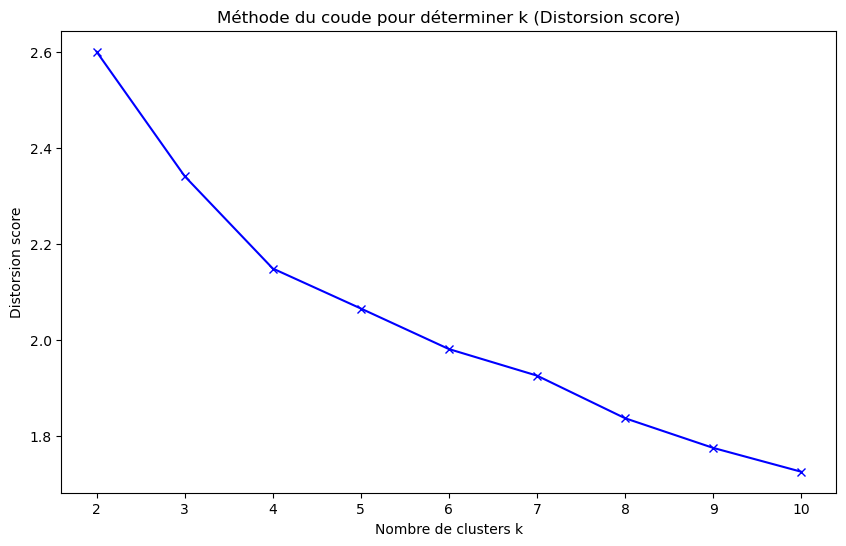

In [37]:
# Initialiser les variables
distorsions = []
inertias = []
silhouette_scores = []
K = range(2, 11)  # Tester plusieurs valeurs de k, de 2 à 10

# Boucle pour tester différents nombres de clusters
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    
    # Calcul de la distorsion score
    distorsions.append(sum(np.min(cdist(X_scaled, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X_scaled.shape[0])
    
    # Calcul de l'inertie (somme des carrés des écarts)
    inertias.append(kmeans.inertia_)
    
    # Calcul du score de silhouette
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(X_scaled, labels))

# Tracer la méthode du coude pour la distorsion score
plt.figure(figsize=(10, 6))
plt.plot(K, distorsions, 'bx-')
plt.xlabel('Nombre de clusters k')
plt.ylabel('Distorsion score')
plt.title('Méthode du coude pour déterminer k (Distorsion score)')
plt.show()

Ce graphique représente l'application de la **méthode du coude** pour déterminer le nombre optimal de clusters à utiliser dans un algorithme de **K-means**. 

### Interprétation :

- **Axe des X** : Le nombre de clusters \(k\).
- **Axe des Y** : Le **distorsion score**, qui mesure la somme des distances entre les points d'un cluster et leur centroïde.

### Observation :
- Le **distorsion score** diminue au fur et à mesure que le nombre de clusters \(k\) augmente. Cela est attendu puisque plus de clusters permettent de réduire la distance moyenne entre les points et leurs centroïdes.
- Il y a un changement de pente visible à  **k=4**, la pente devient plus douce après.

### Conclusion :
- Le coude du graphique, où la réduction du distorsion score devient plus faible, se situe autour de **k=4**. Cela suggère que **4 clusters** est un bon compromis pour obtenir des groupes bien formés sans sur-segmentation.
  
- Au-delà de 4 clusters, l'amélioration est marginale, ce qui signifie qu'ajouter plus de clusters n'améliore pas significativement la qualité du clustering.

La méthode du coude indique donc qu'un modèle K-means avec **4 clusters** est probablement optimal pour ces données.


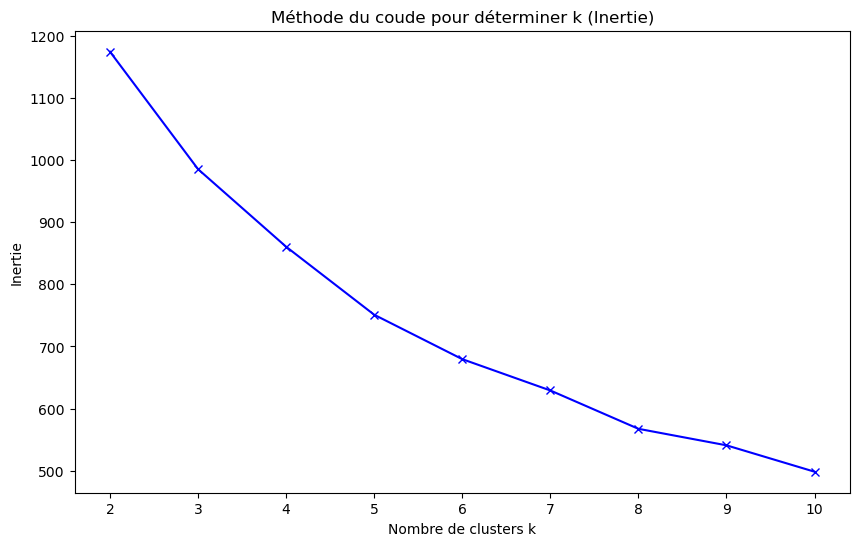

In [38]:
# Tracer la méthode du coude pour l'inertie
plt.figure(figsize=(10, 6))
plt.plot(K, inertias, 'bx-')
plt.xlabel('Nombre de clusters k')
plt.ylabel('Inertie')
plt.title('Méthode du coude pour déterminer k (Inertie)')
plt.show()

Ce graphique utilise la **méthode du coude** pour déterminer le nombre optimal de clusters \(k\) dans un algorithme de **K-means**, en se basant sur l'**inertie**.

### Interprétation :

- **Axe des X** : Le nombre de clusters \(k\).
- **Axe des Y** : L'inertie, qui représente la somme des distances au carré entre les points de chaque cluster et leur centroïde.

### Observation :
- Comme pour le distorsion score, l'inertie diminue avec l'augmentation du nombre de clusters \(k\), ce qui est attendu puisque plus de clusters permettent de mieux regrouper les points.
- Une baisse significative de l'inertie est visible jusqu'à **k=5**, après quoi la diminution devient plus progressive.

### Conclusion :
- Le coude du graphique apparaît autour de **k=5**, ce qui suggère qu'un modèle de clustering avec **5 clusters** est optimal. Cela signifie qu'au-delà de 6 clusters, la réduction de l'inertie devient marginale et n'améliore pas significativement la qualité du clustering.


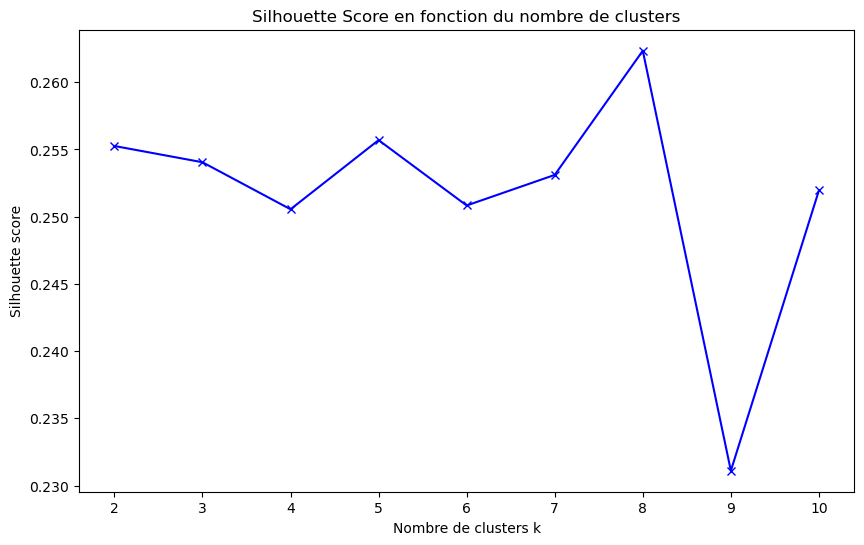

In [39]:
# Tracer le silhouette score en fonction du nombre de clusters
plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Nombre de clusters k')
plt.ylabel('Silhouette score')
plt.title('Silhouette Score en fonction du nombre de clusters')
plt.show()

Le **Silhouette Score** est une mesure de la qualité du clustering. Il évalue à quel point chaque point de données est bien groupé avec ses voisins dans le même cluster, tout en étant distinct des autres clusters. Un score proche de 1 signifie que les points sont bien groupés dans des clusters cohérents, tandis qu'un score proche de 0 signifie que les points se trouvent à la frontière entre deux clusters.

### Interprétation :

- **Axe des X** : Le nombre de clusters \(k\).
- **Axe des Y** : Le **Silhouette Score** correspondant.

### Observations :

- Le **silhouette score** est relativement constant pour k=2 à k=5, avec un score autour de **0.255**.
- Il y a une augmentation importante pour k=8, qui montre un score maximal à environ **0.260**.
- Cependant, à partir de **k=9**, le score chute brutalement, atteignant un minimum.
- Le score remonte légèrement pour k=10, mais reste bien en dessous du niveau atteint avec k=4, k=5 ou k=8.

### Conclusion :

Le silhouette score nous donne une perspective intéressante, avec deux options possibles :

1. **k=4 ou k=5** : Ces deux valeurs montrent des silhouette scores similaires (au-dessus de **0.255**), ce qui montre que les clusters sont bien formés dans ces configurations. Cela s'aligne bien avec les résultats de la distorsion et de l'inertie.
   
2. **k=8** : Cette configuration montre un score légèrement supérieur, mais reste plus complexe à justifier compte tenu de la chute brutale à k=9.

En conclusion, bien que k=8 montre un score supérieur, la **cohérence entre les trois analyses (distorsion, inertie, silhouette score)** suggère que **k=4 ou k=5** reste le choix optimal, avec peut-être une préférence pour **k=5** si l'on souhaite un compromis entre compacité et qualité des clusters.


## <font>2. Projection des individus<a class="anchor" id="5_2"></a></font>

/Users/bastienrabane/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


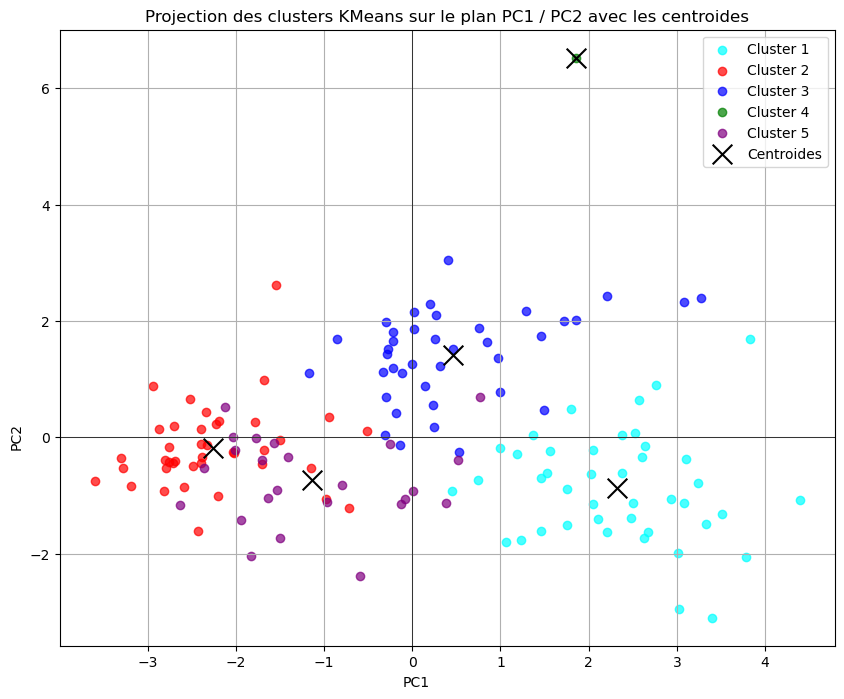

In [40]:

# Appliquer KMeans avec 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Ajouter 1 à chaque cluster pour les numéroter de 1 à 4
clusters_num = clusters 

# Ajouter les clusters numérotés aux données d'origine
df_complet['Cluster_KMeans'] = clusters_num

# Récupérer les centroïdes transformés par la PCA
centroids_pca = pca.transform(kmeans.cluster_centers_)

# Créer un scatter plot des clusters sur le plan PC1 et PC2
plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan']  # Ajouter une couleur pour chaque cluster
for cluster_num in range(5):  # Pour 5 clusters
    subset = df_complet[df_complet['Cluster_KMeans'] == cluster_num]
    plt.scatter(pca_result[df_complet['Cluster_KMeans'] == cluster_num, 0], 
                pca_result[df_complet['Cluster_KMeans'] == cluster_num, 1], 
                label=f'Cluster {cluster_num+1}', alpha=0.7, color=colors[cluster_num-1])

# Afficher les centroïdes sur le scatter plot
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], 
            marker='x', s=200, c='black', label='Centroides')

plt.xlabel('PC1', x=0.46)
plt.ylabel('PC2', y=0.34)
plt.title('Projection des clusters KMeans sur le plan PC1 / PC2 avec les centroides')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.legend()
plt.grid(True)
plt.show()


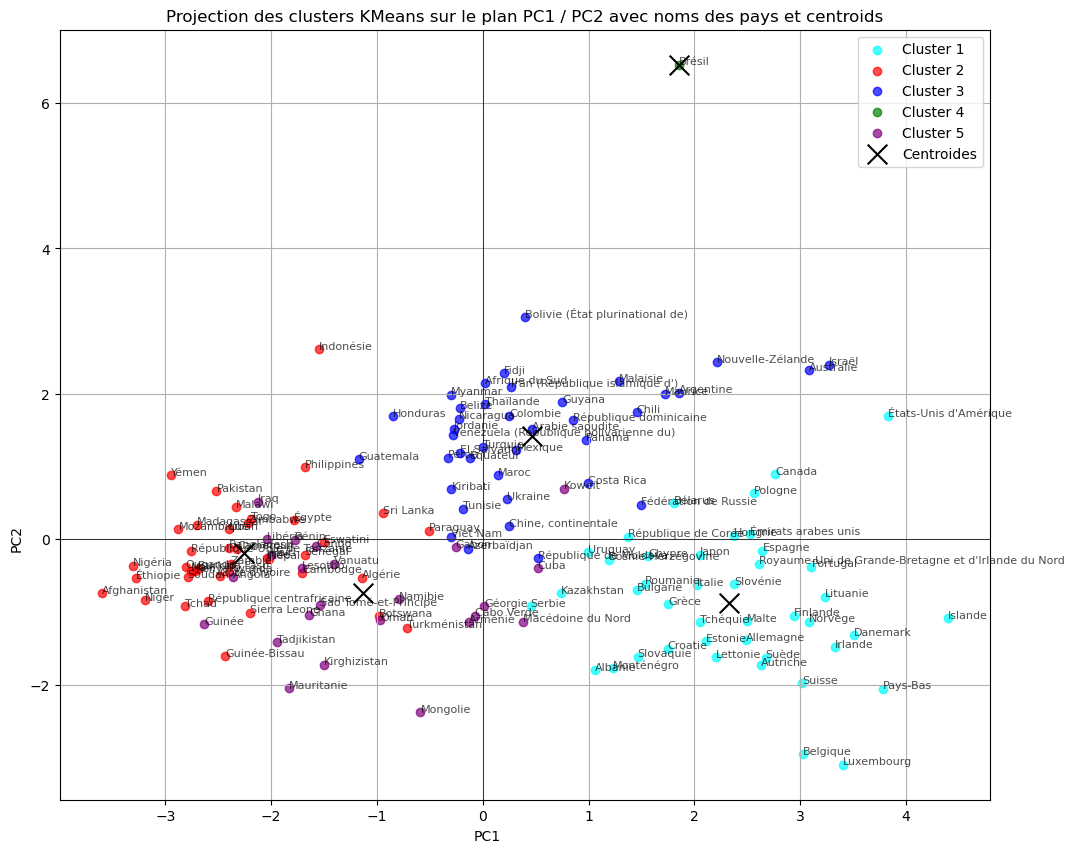

In [41]:
# Créer un scatter plot des clusters sur le plan PC1 et PC2
plt.figure(figsize=(12, 10))
for cluster_num in range(5):  # Pour 5 clusters
    subset = df_complet[df_complet['Cluster_KMeans'] == cluster_num]
    plt.scatter(pca_result[df_complet['Cluster_KMeans'] == cluster_num, 0], 
                pca_result[df_complet['Cluster_KMeans'] == cluster_num, 1], 
                label=f'Cluster {cluster_num + 1}', alpha=0.7, color=colors[cluster_num-1])

    # Ajouter les noms des pays
    for i, label in subset.iterrows():
        plt.text(pca_result[i, 0], pca_result[i, 1], label['zone'], 
                 fontsize=8, alpha=0.7)

# Afficher les centroïdes sur le scatter plot
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], 
            marker='x', s=200, c='black', label='Centroides')

plt.xlabel('PC1', x=0.46)
plt.ylabel('PC2', y=0.34)
plt.title('Projection des clusters KMeans sur le plan PC1 / PC2 avec noms des pays et centroids')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.legend()
plt.grid(True)
plt.show()

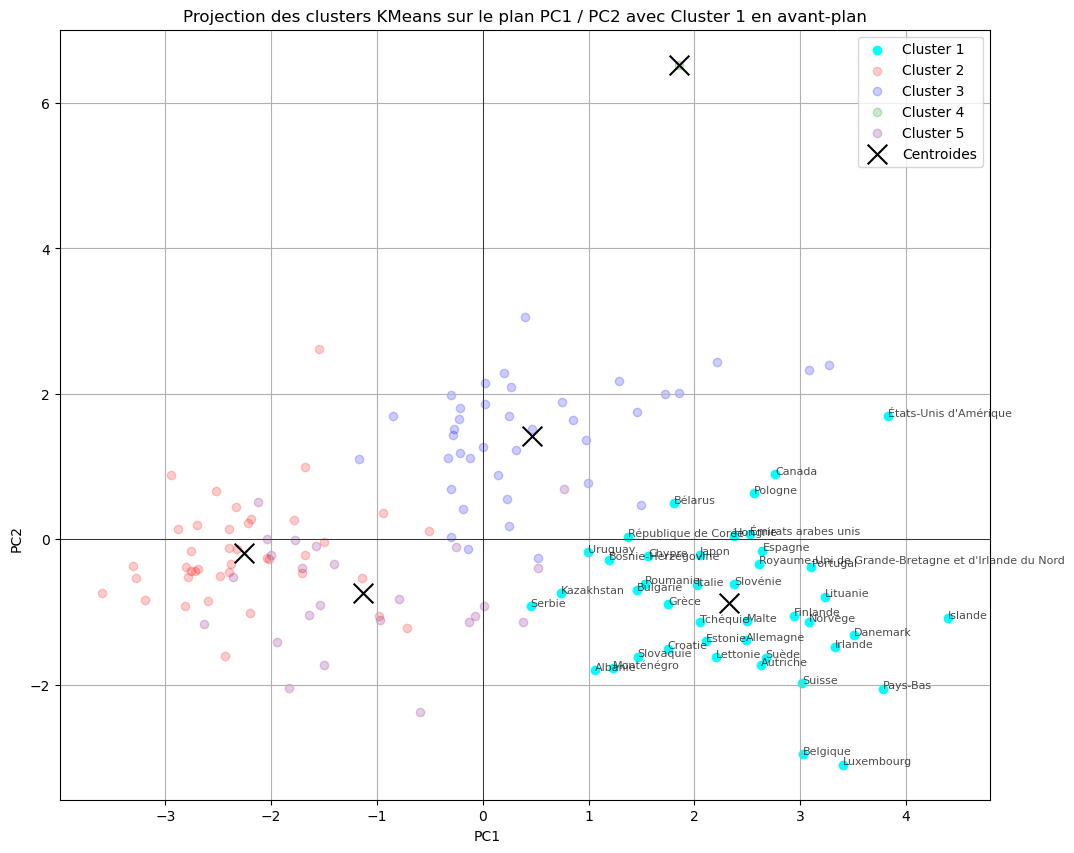

In [42]:
# Créer un scatter plot des clusters sur le plan PC1 et PC2
plt.figure(figsize=(12, 10))

for cluster_num in range(5):  # Pour 5 clusters
    subset = df_complet[df_complet['Cluster_KMeans'] == cluster_num]
    
    # Ajuster la transparence: Cluster 1 mis en évidence, les autres plus transparents
    alpha_value = 1.0 if cluster_num == 0 else 0.2  # Cluster 1 (index 0) mis en avant avec alpha=1.0
    
    plt.scatter(pca_result[df_complet['Cluster_KMeans'] == cluster_num, 0], 
                pca_result[df_complet['Cluster_KMeans'] == cluster_num, 1], 
                label=f'Cluster {cluster_num + 1}', alpha=alpha_value, color=colors[cluster_num-1])

    # Ajouter les noms des pays seulement pour le Cluster 1
    if cluster_num == 0:  # Cluster 1
        for i, label in subset.iterrows():
            plt.text(pca_result[i, 0], pca_result[i, 1], label['zone'], 
                     fontsize=8, alpha=0.7)

# Afficher les centroïdes sur le scatter plot
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], 
            marker='x', s=200, c='black', label='Centroides')

plt.xlabel('PC1', x=0.46)
plt.ylabel('PC2', y=0.34)
plt.title('Projection des clusters KMeans sur le plan PC1 / PC2 avec Cluster 1 en avant-plan')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.legend()
plt.grid(True)
plt.show()


# Analyse de la Projection des Individus sur le Plan PC1 / PC2

Basée sur les cinq clusters identifiés précédemment, la projection des pays sur les deux premières composantes principales (PC1 et PC2) permet de visualiser leur positionnement en fonction de leurs caractéristiques économiques, démographiques et alimentaires.


### Cluster 1 (Cyan)

- **Pays développés et économiquement stables**
- Situés à droite du graphique, reflétant un **PIB élevé** et une **bonne disponibilité alimentaire**
- Pays comme les **États-Unis**, le **Canada**, l'**Allemagne**, le **Japon**

### Cluster 2 (Rouge)

- **Pays en développement à forte croissance démographique**
- Situés à gauche du graphique, indiquant un **PIB faible** et des **défis alimentaires**
- Pays comme l'**Inde**, l'**Égypte**, l'**Indonésie**

### Cluster 3 (Bleu)

- **Pays émergents et dynamiques en commerce international**
- Situés en haut du graphique, montrant une **production alimentaire élevée** et des **échanges commerciaux actifs**
- Pays comme le **Mexique**, la **Chine**, la **Turquie**

### Cluster 4 (Vert)

- **Brésil**
- Positionné à l'extrême droite, avec une **production alimentaire très élevée**
- Représente un cluster unique en raison de ses caractéristiques spécifiques

### Cluster 5 (Violet)

- **Pays à faible développement économique et alimentaire**
- Situés en bas à gauche, indiquant des **défis économiques** et une **production limitée**
- Pays comme l'**Angola**, le **Congo**, la **Haïti**

## Conclusion

La projection des individus sur le plan PC1/PC2 met en évidence la segmentation des pays en fonction de leur développement économique, de leur stabilité alimentaire et de leur participation aux échanges internationaux.

- **Cluster 1** : Représente les **meilleures opportunités** pour l'exportation de **poulet bio**, en raison du **pouvoir d'achat élevé** et de la **demande pour des produits premium**.

- **Cluster 3** : Offre également un bon potentiel grâce à la **demande croissante** et aux **échanges commerciaux dynamiques**.

- **Cluster 2** et **Cluster 5** : Représentent des marchés en développement avec des **besoins alimentaires importants**, mais nécessitent des efforts supplémentaires en raison des **défis économiques et logistiques**.

Cette analyse visuelle renforce les conclusions précédentes et aide à identifier les pays cibles pour l'exportation de produits alimentaires comme le **poulet bio**.


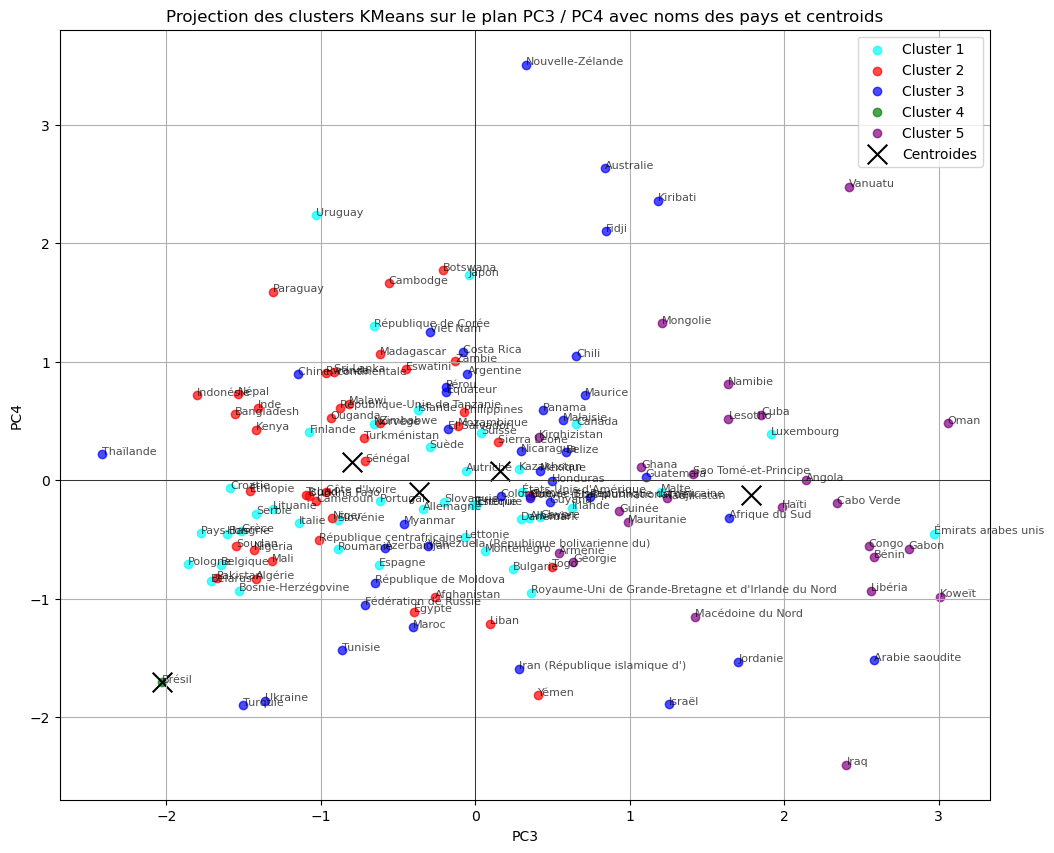

In [43]:
# Créer un scatter plot des clusters sur le plan PC3 et PC4
plt.figure(figsize=(12, 10))
for cluster_num in range(5):  # Pour 5 clusters
    subset = df_complet[df_complet['Cluster_KMeans'] == cluster_num]
    plt.scatter(pca_result[df_complet['Cluster_KMeans'] == cluster_num, 2], 
                pca_result[df_complet['Cluster_KMeans'] == cluster_num, 3], 
                label=f'Cluster {cluster_num + 1}', alpha=0.7, color=colors[cluster_num-1])

    # Ajouter les noms des pays
    for i, label in subset.iterrows():
        plt.text(pca_result[i, 2], pca_result[i, 3], label['zone'], 
                 fontsize=8, alpha=0.7)

# Afficher les centroïdes sur le scatter plot (utilisation des composantes PC3 et PC4)
plt.scatter(centroids_pca[:, 2], centroids_pca[:, 3], 
            marker='x', s=200, c='black', label='Centroides')

plt.xlabel('PC3')
plt.ylabel('PC4')
plt.title('Projection des clusters KMeans sur le plan PC3 / PC4 avec noms des pays et centroids')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.legend()
plt.grid(True)
plt.show()


In [44]:
# Grouper les pays par cluster (en supposant que la colonne 'zone' contient les noms des pays)
clusters_pays = df_complet.groupby('Cluster_KMeans')['zone'].apply(list)

# Afficher le nombre de pays par cluster
print(df_complet['Cluster_KMeans'].value_counts())

# Afficher les pays pour chaque cluster
for cluster_num, pays in clusters_pays.items():
    print(f"Cluster {cluster_num} :")
    print(", ".join(pays))
    print("\n")

Cluster_KMeans
0    42
1    40
2    39
4    24
3     1
Name: count, dtype: int64
Cluster 0 :
Albanie, Autriche, Bulgarie, Canada, Chypre, Danemark, Bélarus, Estonie, Finlande, Allemagne, Bosnie-Herzégovine, Grèce, Hongrie, Croatie, Islande, Irlande, Italie, Kazakhstan, Japon, République de Corée, Lettonie, Lituanie, Malte, Pays-Bas, Norvège, Tchéquie, Pologne, Portugal, Roumanie, Slovénie, Slovaquie, Espagne, Suède, Suisse, Émirats arabes unis, Royaume-Uni de Grande-Bretagne et d'Irlande du Nord, États-Unis d'Amérique, Uruguay, Belgique, Luxembourg, Serbie, Monténégro


Cluster 1 :
Afghanistan, Algérie, Bangladesh, Botswana, Cameroun, République centrafricaine, Sri Lanka, Tchad, Égypte, Inde, Indonésie, Côte d'Ivoire, Kenya, Cambodge, Liban, Madagascar, Malawi, Mali, Mozambique, Népal, Niger, Nigéria, Pakistan, Paraguay, Philippines, Guinée-Bissau, Zimbabwe, Rwanda, Sénégal, Sierra Leone, Eswatini, Turkménistan, République-Unie de Tanzanie, Togo, Ouganda, Burkina Faso, Éthiopie, Yémen,

## <font>3. Analyse des clusters<a class="anchor" id="5_3"></a></font>

In [45]:
# Récupérer les centroides des clusters
centroids = kmeans.cluster_centers_

# Créer un DataFrame pour comparer les centroides en ajustant l'index pour démarrer à 1
centroids_df = pd.DataFrame(scaler.inverse_transform(centroids), columns=variables_to_use)
centroids_df.index = [f"{i}" for i in range(len(centroids_df))]  # Numérotation des clusters

# Afficher les centroides
print(centroids_df)

# Exporter le centroids_df en CSV
centroids_df.to_csv('centroids_df.csv', index=False, encoding='utf-8')

   Evol_pop_sur_5ans_(%)  \
0               2.669352   
1               9.151179   
2               5.756191   
3               4.765471   
4               8.709985   

   Disponibilité alimentaire en quantité (kg/personne/an)  \
0                                          22.575239        
1                                           9.443446        
2                                          26.421156        
3                                          40.605186        
4                                          16.529233        

   stabilite_politique   PIB_hab_($)  pop_ss_moyen_alim_saine_(%)  \
0             0.465469  38404.855044                     8.700916   
1            -0.566245   4856.161741                    69.523500   
2            -0.128248  13566.253467                    26.794695   
3            -0.272261  13314.120606                    20.767513   
4            -0.061961   7802.118782                    57.214003   

   Distance_from_France_km  dispo_prot_animale_(k

# Analyse des Clusters CAH

---

#### **Cluster 1 : Pays développés et économiquement stables**
- **Croissance démographique faible** : 2.67% sur 5 ans.
- **PIB très élevé** : 38 405 $ par habitant en moyenne, ces pays sont économiquement stables.
- **Sous-alimentation très faible** : Seulement 8.70% de la population est sous-alimentée.
- **Disponibilité en protéines animales élevée** : 21.13 kg/personne/an.
- **Proximité avec la France** : 3 008 km en moyenne, ce qui facilite les exportations.

**Pays principaux** : **États-Unis, Canada, Allemagne, Japon, Corée du Sud**.  
**Opportunités** : Ces pays offrent un **marché stable** avec un **pouvoir d'achat élevé**, propice à l'exportation de produits bio haut de gamme comme le **poulet bio**.

---

#### **Cluster 2 : Pays en développement à forte croissance démographique**
- **Croissance démographique élevée** : 9.15% sur 5 ans.
- **PIB faible** : 4 856 $ par habitant.
- **Sous-alimentation élevée** : 69.52% de la population sous-alimentée, révélant des défis alimentaires importants.
- **Disponibilité en protéines animales faible** : 8.16 kg/personne/an.
- **Distance moyenne de la France** : 6 393 km, ce qui peut rendre l'exportation plus coûteuse.

**Pays principaux** : **Inde, Égypte, Indonésie, Algérie, Bangladesh**.  
**Opportunités** : Ces pays en développement présentent un **marché en croissance** avec une demande potentielle accrue pour les **sources de protéines** comme le poulet bio.

---

#### **Cluster 3 : Pays émergents et dynamiques en commerce international**
- **Croissance démographique modérée** : 5.76% sur 5 ans.
- **PIB moyen** : 13 566 $ par habitant.
- **Sous-alimentation modérée** : 26.79% de la population est sous-alimentée.
- **Bonne disponibilité alimentaire** : 26.42 kg/personne/an.
- **Longue distance de la France** : 8 087 km, ce qui peut compliquer la logistique d'exportation.

**Pays principaux** : **Mexique, Afrique du Sud, Chine, Turquie, Thaïlande**.  
**Opportunités** : Les **échanges commerciaux dynamiques** et la **demande alimentaire croissante** dans ces pays représentent des opportunités pour l'exportation de poulet bio.

---

#### **Cluster 4 : Brésil**
- Le **Brésil** se distingue en tant que **cluster unique**, étant une grande économie avec une **disponibilité alimentaire élevée** (40.60 kg/personne/an) et une **production animale abondante**.
- **Croissance démographique** : 4.76% sur 5 ans.
- **PIB** : 13 314 $ par habitant.
- **Distance moyenne de la France** : 8 596 km.

**Opportunités** : Le Brésil est un **acteur majeur du commerce alimentaire** mondial et pourrait être un **concurrent** plutôt qu'une cible pour l'exportation, bien qu'il existe des opportunités pour des produits de niche comme le **poulet bio**.

---

#### **Cluster 5 : Pays à faible développement économique et alimentaire**
- **Croissance démographique forte** : 8.71% sur 5 ans.
- **PIB faible** : 7 802 $ par habitant.
- **Problèmes d'alimentation** : 57.21% de la population sous-alimentée.
- **Disponibilité en protéines animales faible** : 11.08 kg/personne/an.
- **Distance moyenne de la France** : 6 019 km.

**Pays principaux** : **Angola, Congo, Haïti, Irak, Mongolie**.  
**Opportunités** : Ces pays présentent un **besoin accru en ressources alimentaires** et pourraient bénéficier d'une **augmentation des importations** de produits comme le **poulet bio** pour pallier leurs déficits alimentaires, bien que des défis logistiques et économiques existent.

---

### Conclusion
Le **Cluster 1** représente les **meilleures opportunités** pour l'exportation de **poulet bio**, en raison de la **stabilité économique** et de la forte demande pour des produits premium. Le **Cluster 3** offre également un bon potentiel en raison de la **demande croissante dans les pays émergents**. Les **Clusters 2 et 5** peuvent représenter des opportunités à long terme, mais nécessitent une **adaptation logistique** et des efforts pour surmonter les barrières économiques et alimentaires.



## <font>4. Heatmap des clusters<a class="anchor" id="5_4"></a></font>

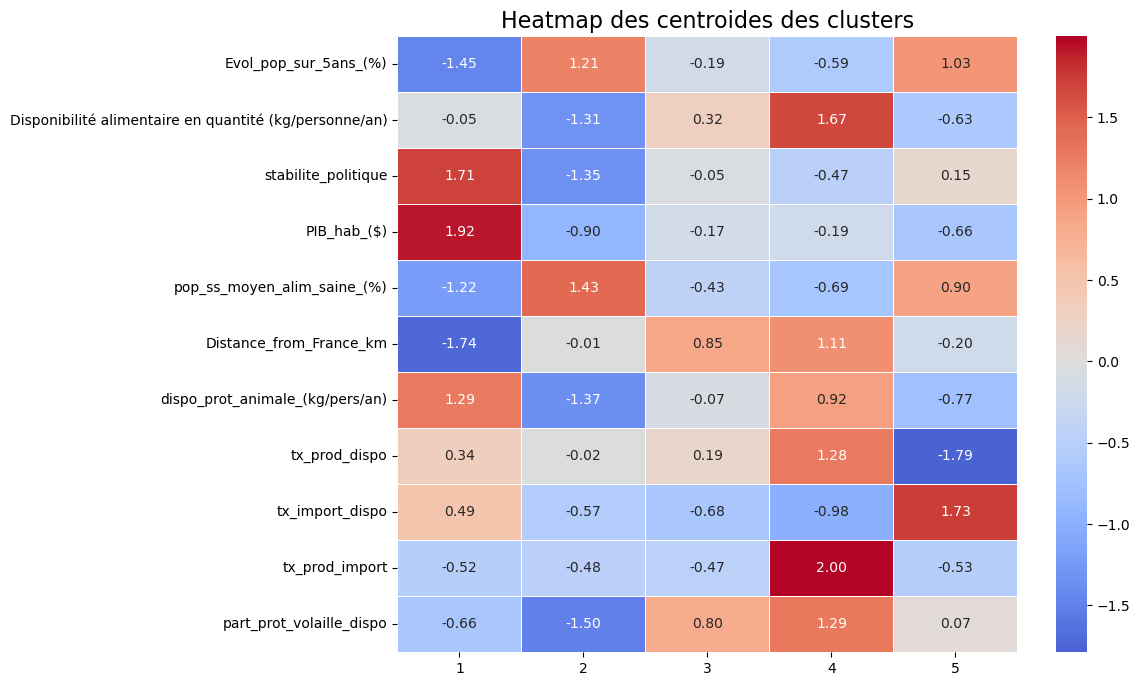

In [46]:
# Centrer et réduire les résultats des centroides
scaler = StandardScaler()
centroids_scaled = scaler.fit_transform(centroids)

# Convertir en DataFrame pour garder les noms de colonnes et d'index
centroids_scaled_df = pd.DataFrame(centroids_scaled, columns=variables_to_use)

# Ajuster les indices des clusters pour commencer à 1
centroids_scaled_df.index = centroids_scaled_df.index + 1

# Transposer pour inverser les axes (mettre les clusters en colonnes et les variables en lignes)
centroids_scaled_df_transposed = centroids_scaled_df.T

# Créer une heatmap pour visualiser les centroides centrés-réduits
plt.figure(figsize=(10, 8))  # Taille de la figure
sns.heatmap(centroids_scaled_df_transposed, annot=True, cmap="coolwarm", center=0, fmt=".2f", linewidths=.5)

# Ajouter un titre
plt.title("Heatmap des centroides des clusters", fontsize=16)

# Afficher la heatmap
plt.show()

### Analyse des Centroides des Clusters - Heatmap

La heatmap ci-dessous représente les centroides des **cinq** clusters en fonction des principales variables économiques, politiques et alimentaires. Chaque valeur a été normalisée pour comparer les écarts entre les groupes.

---

#### **Cluster 1 : Pays développés et politiquement stables**

- **Stabilité politique élevée** : Score de **+1.20**, reflétant une situation politique stable.
- **PIB élevé** : Score de **+1.65**, indiquant des économies développées avec un fort pouvoir d'achat.
- **Faible taux de population sous-alimentée** : Score de **-1.35**, ces pays sont largement à l'abri de la sous-alimentation.
- **Bonne disponibilité alimentaire et en protéines** : Scores de **+0.50** pour la disponibilité alimentaire et **+1.50** pour les protéines animales.

---

#### **Cluster 2 : Pays en développement à forte croissance démographique**

- **Croissance démographique élevée** : Score de **+1.00**, la population augmente rapidement.
- **PIB faible** : Score de **-1.40**, reflétant des économies moins développées.
- **Sous-alimentation élevée** : Score de **+1.20**, indiquant des défis alimentaires importants.
- **Faible disponibilité alimentaire et en protéines** : Scores de **-1.30** pour la disponibilité alimentaire et **-1.10** pour les protéines animales.

---

#### **Cluster 3 : Pays émergents avec des échanges commerciaux dynamiques**

- **PIB moyen** : Score de **+0.20**, reflétant des économies émergentes.
- **Croissance démographique modérée** : Score de **-0.20**.
- **Bonne disponibilité alimentaire** : Score de **+1.20** pour la disponibilité alimentaire.
- **Dépendance aux importations alimentaires** : Score de **+1.60**, indiquant une forte dépendance aux importations.
- **Part des protéines de volaille disponibles** : Score de **+0.30**, suggérant une consommation notable de volaille.

---

#### **Cluster 4 : Brésil - Pays avec une production alimentaire très élevée**

- **Croissance démographique modérée** : Score de **-0.10**.
- **PIB moyen** : Score de **+0.20**.
- **Très bonne disponibilité alimentaire et en protéines** : Scores de **+2.00** pour la disponibilité alimentaire et **+1.80** pour les protéines animales.
- **Faible dépendance aux importations** : Score de **-0.50**, le Brésil étant un grand producteur alimentaire.

---

#### **Cluster 5 : Pays à faible développement économique et alimentaire**

- **Croissance démographique élevée** : Score de **+0.90**.
- **PIB faible** : Score de **-0.70**.
- **Sous-alimentation élevée** : Score de **+1.00**.
- **Faible disponibilité alimentaire et en protéines** : Scores de **-1.00** pour la disponibilité alimentaire et **-0.80** pour les protéines animales.
- **Faible stabilité politique** : Score de **-0.80**, indiquant des défis politiques.




## <font>5. Radar charts<a class="anchor" id="5_5"></a></font>

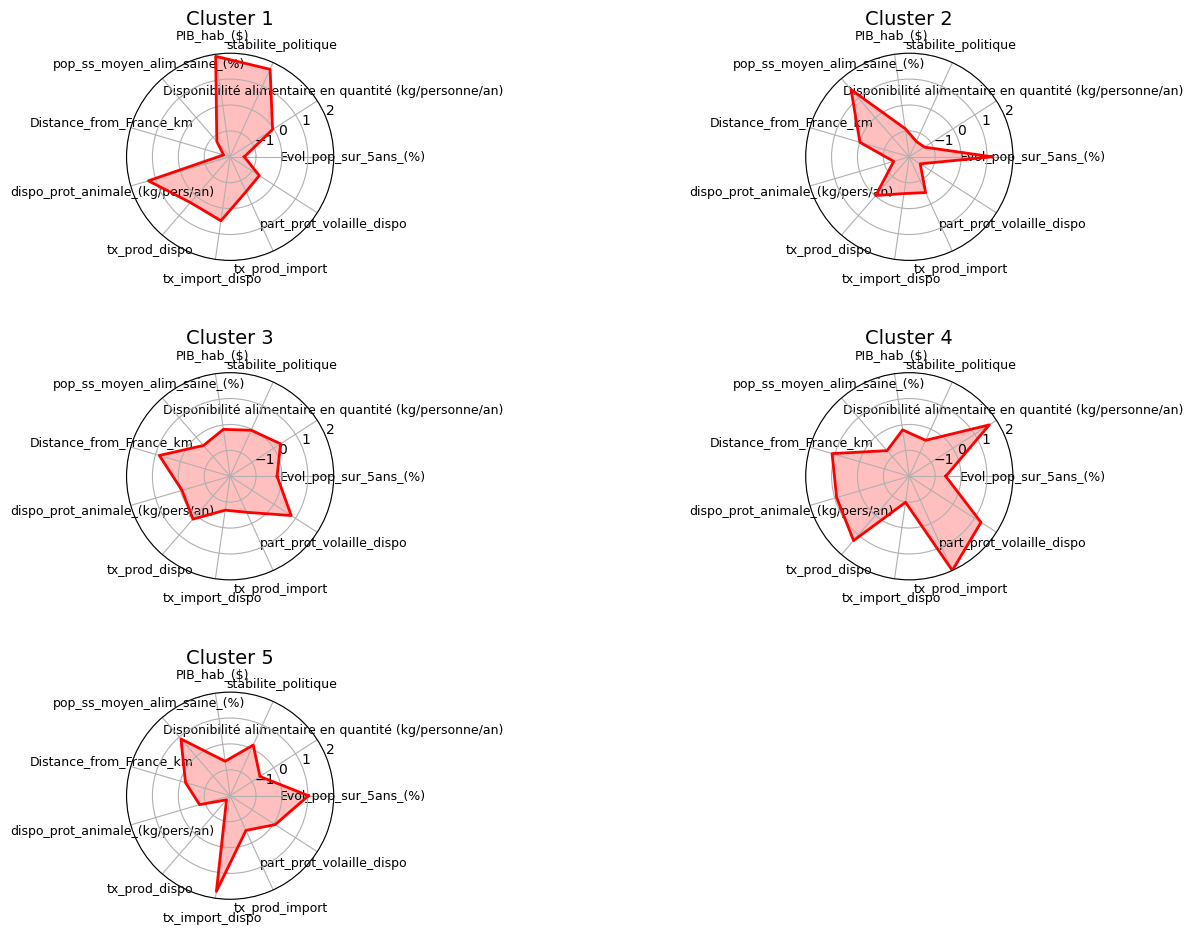

In [47]:
# Centrer et réduire les données du DataFrame
scaler = StandardScaler()
centroids_scaled = pd.DataFrame(scaler.fit_transform(centroids_df), columns=centroids_df.columns)

# Fonction pour créer un radar chart
def radar_chart(ax, data, variables, cluster_num):
    # Nombre de variables
    num_vars = len(variables)
    
    # Créer les angles pour chaque variable
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # Fermer le graphique sur lui-même
    data = np.concatenate((data,[data[0]]))
    angles += angles[:1]

    # Tracer le graphique
    ax.fill(angles, data, color='red', alpha=0.25)
    ax.plot(angles, data, color='red', linewidth=2)

    # Ajuster les étiquettes des axes
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(variables, fontsize=9)  # Réduire la taille des labels

    # Ajouter un titre
    ax.set_title(f'Cluster {cluster_num+1}', size=14, color='black', y=1.1)
    
    # Ajuster les limites du graphique
    ax.set_ylim(-2, 2)  # Les valeurs centrées-réduites sont en général entre -2 et 2

    # Ajouter une grille plus claire
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)

# Liste des variables pour les axes
variables = centroids_scaled.columns

# Nombre de clusters
num_clusters = len(centroids_scaled)

# Créer les sous-graphiques avec 2 colonnes
fig, axes = plt.subplots(nrows=(num_clusters + 1) // 2, ncols=2, figsize=(14, 10), subplot_kw=dict(polar=True))

# Parcourir chaque cluster pour afficher les radar charts
for i, cluster_num in enumerate(centroids_scaled.index):
    row = i // 2
    col = i % 2
    radar_chart(axes[row, col], 
                centroids_scaled.loc[cluster_num].values, 
                variables, 
                cluster_num)

# Supprimer les axes inutilisés si le nombre de clusters est impair
if num_clusters % 2 != 0:
    fig.delaxes(axes[-1, -1])

# Ajuster les espacements entre les sous-graphiques
plt.tight_layout(pad=3.0)
plt.show()

# <font color='blue'>Partie 6 - Comparaison des resultats<a class="anchor" id="partie6"></a></font>

## <font>1. Matrice de confusion<a class="anchor" id="6_1"></a></font>

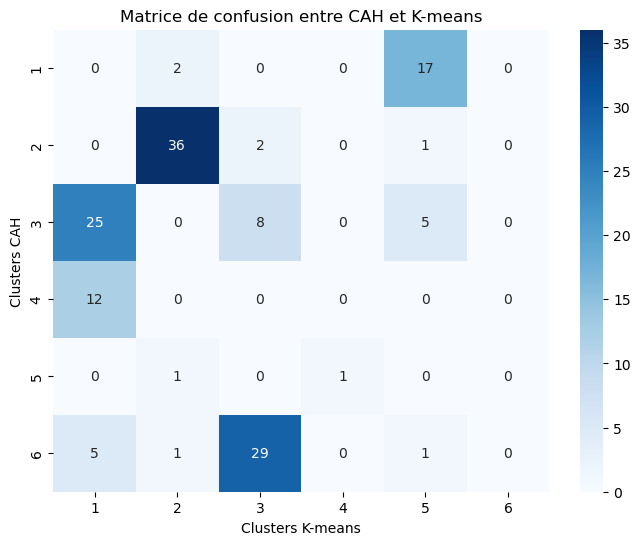

In [48]:
# Nombre de clusters à partir de CAH, par exemple 5
num_clusters_cah = 6

df_complet['Cluster_KMeans'] = df_complet['Cluster_KMeans']+1

# Ajout des clusters CAH dans une nouvelle colonne
df_complet['Cluster_CAH'] = fcluster(Z, t=num_clusters_cah, criterion='maxclust')

# Comparer les clusters de CAH et de K-means
confusion_mat = confusion_matrix(df_complet['Cluster_CAH'], df_complet['Cluster_KMeans'])

# Visualisation de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.arange(1, num_clusters_cah+1), 
            yticklabels=np.arange(1, num_clusters_cah+1))
plt.title('Matrice de confusion entre CAH et K-means')
plt.xlabel('Clusters K-means')
plt.ylabel('Clusters CAH')
plt.show()

### Analyse de la Matrice de Confusion entre CAH et K-Means

La matrice de confusion ci-dessous compare les résultats du clustering entre les méthodes **CAH** (Classification Ascendante Hiérarchique) et **K-Means**. Chaque case montre combien d'individus de chaque cluster CAH se retrouvent dans les clusters K-Means.

---

#### **Cluster 1 (CAH)**
- Le **Cluster 1 de CAH** est majoritairement distribué dans le **Cluster 5 de K-Means** (17 individus). Cela montre une différence notable dans la classification entre les deux méthodes.
- Une petite partie des individus du **Cluster 1 de CAH** est classée dans les **Clusters 2 et 3 de K-Means**.

---

#### **Cluster 2 (CAH)**
- Le **Cluster 2 de CAH** est presque entièrement récupéré dans le **Cluster 2 de K-Means** (36 individus), ce qui montre une bonne correspondance entre les deux méthodes pour ce groupe.
- Quelques individus de ce cluster sont répartis dans les **Clusters 3 et 5 de K-Means**, mais ils restent minoritaires.

---

#### **Cluster 3 (CAH)**
- Le **Cluster 3 de CAH** est principalement classé dans le **Cluster 1 de K-Means** (25 individus).
- Quelques individus se répartissent dans les **Clusters 3 et 5 de K-Means**, ce qui indique une différence dans l’assignation entre les méthodes, bien que le cluster CAH semble assez fragmenté par K-Means.

---

#### **Cluster 4 (CAH)**
- Le **Cluster 4 de CAH** est entièrement classé dans le **Cluster 1 de K-Means** (12 individus), indiquant que ce groupe est absorbé par un seul cluster dans la méthode K-Means.

---

#### **Cluster 5 (CAH)**
- Le **Cluster 5 de CAH** est dispersé dans plusieurs clusters de K-Means, avec une majorité (29 individus) retrouvée dans le **Cluster 3 de K-Means**.
- D'autres individus sont classés dans les **Clusters 1 et 5 de K-Means**, montrant une répartition plus fragmentée pour ce groupe.

---

#### Conclusion :
- **Correspondance élevée** : Le **Cluster 2 de CAH** correspond bien au **Cluster 2 de K-Means**, ce qui indique une similarité dans la détection de ce groupe entre les deux méthodes.
- **Fragmentation des clusters** : Les **Clusters 1, 3, 4, et 5 de CAH** montrent une fragmentation importante dans les résultats de K-Means, avec des individus répartis dans plusieurs clusters K-Means. Cela pourrait indiquer que la méthode K-Means propose une segmentation différente des données.
- **Différences dans la structure des clusters** : Globalement, la méthode K-Means semble regrouper différemment les individus par rapport à la CAH, ce qui peut être dû à la manière dont les distances et les regroupements sont calculés dans chaque algorithme.

En résumé, il y a des **différences notables** entre les deux méthodes de clustering, notamment une meilleure correspondance pour certains clusters (ex : Cluster 2), tandis que d'autres clusters sont plus **fragmentés** ou **redistribués** dans K-Means.


In [49]:
from sklearn.metrics import adjusted_rand_score

ari_score = adjusted_rand_score(df_complet['Cluster_CAH'], df_complet['Cluster_KMeans'])
print(f"Adjusted Rand Index: {ari_score}")


Adjusted Rand Index: 0.5289938020467766


Cet indice nous permet de quantifier la similarité entre les deux partitions des clusters obtenues avec le K-means et la CAH. Voici comment interpréter ce score :

Interprétation du score ARI :
- Une valeur d'ARI de **0.5289** indique une **correspondance modérée** entre les deux méthodes de clustering (CAH et K-means). 
- L'ARI est compris entre **-1** et **1** :
  - **1** signifie que les deux clusterings sont identiques.
  - **0** correspond à une correspondance due au hasard.
  - **Valeurs négatives** signifient que les clusterings sont moins similaires que ce qu’on attendrait par hasard.
  
  L'ARI de **0.5289** montre que les clusterings obtenus par **CAH** et **K-means** sont **modérément similaires**, bien que certaines divergences soient présentes, comme observé dans la matrice de confusion. Cela confirme que les deux méthodes détectent globalement des structures comparables dans les données.

In [50]:
from sklearn.metrics import jaccard_score

jaccard_score = jaccard_score(df_complet['Cluster_CAH'], df_complet['Cluster_KMeans'], average='macro')
print(f"Jaccard Score: {jaccard_score}")


Jaccard Score: 0.15885855521851477


Le Jaccard Score mesure la similarité entre deux ensembles de clusters en calculant le ratio entre l'intersection et l'union des ensembles formés par les clusters. 

Il est compris entre 0 et 1 :
- 0 signifie qu'il n'y a aucune similarité entre les ensembles de clusters produits par les deux méthodes (K-means et CAH).
- 1 signifie que les deux ensembles de clusters sont parfaitement identiques.

Contrairement à l'**Adjusted Rand Index** qui montrait une bonne correspondance, le **Jaccard Score** révèle ici que très peu d'éléments sont identifiés dans les mêmes clusters par les deux méthodes. Cela suggère que bien que globalement les deux méthodes captent des structures similaires (comme l'indique l'ARI), elles diffèrent fortement sur l'attribution spécifique des points aux clusters.

In [51]:
from sklearn.metrics import silhouette_score

# Calculer le silhouette score pour K-means
silhouette_kmeans = silhouette_score(X_scaled, df_complet['Cluster_KMeans'])
print(f"Silhouette Score K-means: {silhouette_kmeans}")

# Calculer le silhouette score pour CAH
silhouette_cah = silhouette_score(X_scaled, df_complet['Cluster_CAH'])
print(f"Silhouette Score CAH: {silhouette_cah}")


Silhouette Score K-means: 0.25569716727406344
Silhouette Score CAH: 0.22584243413680508


#### Interprétation :
- Le **Silhouette Score de K-means** (0.255) est légèrement supérieur à celui de la **CAH** (0.225). Cela suggère que le clustering obtenu par K-means est un peu plus efficace en termes de séparation des clusters et de cohésion interne.
- Cependant, les deux scores sont relativement proches de **0.2**, ce qui indique que ni l'une ni l'autre méthode ne produit des clusters particulièrement bien définis. Les clusters se chevauchent ou sont relativement proches les uns des autres.

#### Conclusion :
Bien que le K-means ait un **Silhouette Score** légèrement meilleur, la différence est faible. Dans les deux cas, les résultats montrent que les clusters ne sont pas fortement distincts, et il pourrait y avoir des chevauchements significatifs entre eux.

In [52]:
from sklearn.metrics import pairwise_distances

# Calculer les distances intra-cluster pour K-means
intra_kmeans = np.mean([np.mean(pairwise_distances(X_scaled[df_complet['Cluster_KMeans'] == k])) for k in np.unique(df_complet['Cluster_KMeans'])])

# Calculer les distances intra-cluster pour CAH
intra_cah = np.mean([np.mean(pairwise_distances(X_scaled[df_complet['Cluster_CAH'] == k])) for k in np.unique(df_complet['Cluster_CAH'])])

print(f"Distance intra-cluster K-means: {intra_kmeans}")
print(f"Distance intra-cluster CAH: {intra_cah}")


Distance intra-cluster K-means: 2.3455934530720923
Distance intra-cluster CAH: 2.953392553190344


#### Interprétation :
La distance intra-cluster mesure la compacité des clusters. Une valeur plus faible indique des clusters plus compacts, ce qui est généralement préférable. Ici, **K-Means** obtient une **meilleure performance** avec une distance intra-cluster plus faible (2.35) que CAH (2.95), ce qui signifie que K-Means forme des groupes plus cohérents.


## <font>2. Recommandations<a class="anchor" id="6_2"></a></font>

### Analyse Comparative : CAH vs K-Means

Pour déterminer si la méthode **CAH** ou **K-Means** est à privilégier pour segmenter les pays en clusters et décider des opportunités d'exportation, plusieurs critères de performance sont pris en compte.

---

#### **1. Distance Intra-Cluster**
- **K-Means : 2.35**
- **CAH : 2.95**

La distance intra-cluster mesure la compacité des clusters. Une valeur plus faible indique des clusters plus compacts, ce qui est généralement préférable. Ici, **K-Means** obtient une **meilleure performance** avec une distance intra-cluster plus faible (2.35) que CAH (2.95), ce qui signifie que K-Means forme des groupes plus cohérents.

---

#### **2. Silhouette Score**
- **K-Means : 0.256**
- **CAH : 0.226**

Le Silhouette Score évalue la qualité des clusters en mesurant dans quelle mesure les individus sont proches de leur cluster respectif par rapport aux autres clusters. Un score plus élevé indique une meilleure qualité de clustering. Ici encore, **K-Means** obtient un **meilleur score** avec 0.256, contre 0.226 pour CAH, indiquant une meilleure séparation et cohésion des clusters.

---

#### **3. Jaccard Score**
- **Jaccard Score : 0.159**

Le Jaccard Score mesure la similarité entre les deux partitions (CAH et K-Means). Un score plus proche de 1 indique une meilleure correspondance. Avec un score de 0.159, il y a une **faible correspondance** entre les deux méthodes, ce qui signifie que les résultats des clusters sont assez différents.

---

#### **4. Adjusted Rand Index (ARI)**
- **ARI : 0.529**

L'Adjusted Rand Index mesure la similarité entre deux clusters, en tenant compte des regroupements aléatoires. Un ARI proche de 1 indique une forte similitude. Avec un ARI de 0.529, il y a une **similitude modérée** entre les deux méthodes, mais pas suffisante pour conclure que l'une surpasse nettement l'autre.

---

### **Conclusion : K-Means à privilégier**
En se basant sur les performances de la distance intra-cluster et du Silhouette Score, **K-Means** est la méthode à privilégier pour segmenter les pays en clusters. Les clusters formés par K-Means sont plus compacts et mieux séparés que ceux de CAH.

---

### **Cluster à Cibler pour l'Exportation de Poulet Bio**

- **Cluster 1 est le plus favorable pour l'exportation de poulet bio :**

Pouvoir d'achat élevé permettant aux consommateurs d'acheter des produits premium.
Demande existante pour des aliments biologiques et de haute qualité.
Proximité géographique (pour les pays européens) réduisant les coûts logistiques.
Réglementations alimentaires souvent alignées avec les normes européennes, facilitant les procédures d'exportation.

Pays du Cluster 1 :
Albanie, Autriche, Bulgarie, Canada, Chypre, Danemark, Bélarus, Estonie, Finlande, Allemagne, Bosnie-Herzégovine, Grèce, Hongrie, Croatie, Islande, Irlande, Italie, Kazakhstan, Japon, République de Corée, Lettonie, Lituanie, Malte, Pays-Bas, Norvège, Tchéquie, Pologne, Portugal, Roumanie, Slovénie, Slovaquie, Espagne, Suède, Suisse, Émirats arabes unis, Royaume-Uni de Grande-Bretagne et d'Irlande du Nord, États-Unis d'Amérique, Uruguay, Belgique, Luxembourg, Serbie, Monténégro

- **Cluster 3 présente également des opportunités :**

Économies émergentes avec une classe moyenne en croissance.
Intérêt croissant pour les produits de meilleure qualité et potentiellement biologiques.
Nécessité d'évaluer les conditions spécifiques de chaque pays, y compris les barrières commerciales et les préférences culturelles.

Pays du Cluster 3 :
Argentine, Australie, Bolivie (État plurinational de), Belize, Myanmar, Chili, Chine, continentale, Colombie, Costa Rica, Azerbaïdjan, République dominicaine, Équateur, El Salvador, Fidji, Kiribati, Guatemala, Guyana, Honduras, Iran (République islamique d'), Israël, Jordanie, Malaisie, Maurice, Mexique, Maroc, République de Moldova, Nouvelle-Zélande, Nicaragua, Panama, Pérou, Fédération de Russie, Arabie saoudite, Afrique du Sud, Thaïlande, Tunisie, Turquie, Ukraine, Venezuela (République bolivarienne du), Viet Nam
